## Problem Statement
* In general, smart home technologies have a tendency to tender good quality for temperature, relative humidity and pressure in a real time manner. However, it may cause more computational operations and more security problems (data goes one part home to another location everytime). Alternatively, we can create a recomendatiton system to navigate users in a better way. If our all metrics is enough to construct an automation system, it can be a better alternative than the real time smart home systems.
* According to my research , smart homes needs data in some interval such as hourly or 10 minutes. In this work, I tried to find temperature, air pressure and relative humidity forecast of living room in 10 minutes intervals.
* The data come from China. It includes weather infromations for 6 room as well as outdoor weather data. Also, it has power consumption data. We can access via this link:
> https://springernature.figshare.com/articles/dataset/The_CN-OBEE_dataset_occupant_behavior_thermal_environment_and_appliance_electricity_use_of_a_single-family_apartment_in_China/23686476
* If you want to know more you can get it via this this:
>https://www.nature.com/articles/s41597-023-02891-9

##Data Preparation
This section includes:
* Importing libraries
* Data uploading
* Outdoor_weather `time` column arrangement and concatenation
> Outdoor_weather dataset has hourly time intervals. However, other datasets has minutely time intervals. We assume that on the same hour weather values are the same.
* Adding air conditioner data into other datasets
* Check object types and arrange them
* Check None or Null rates and arrange them
* Arrange data interaval of 10 minutes

In [ ]:
# Import libraries
!pip install keras-tuner
from google.colab import drive
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import keras
import tensorflow as tf
from keras.models import Sequential
from keras import layers,regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,roc_curve, auc, roc_auc_score
import json
import csv
from enum import auto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Zip documentations
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Zip documentations
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/smart_home_project/The CN-OBEE dataset.zip"
extract_path = "/content/extracted_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

data_directory = "/content/extracted_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Upload Datasets
mutual_dir = "/content/extracted_data/The CN-OBEE dataset/"
cloakroom = pd.read_csv(mutual_dir + "Cloakroom.csv")
home_office = pd.read_csv(mutual_dir + "Home_office.csv")
kitchen = pd.read_csv(mutual_dir + "Kitchen.csv")
living_room = pd.read_csv(mutual_dir + "Living_room.csv")
master_bedroom = pd.read_csv(mutual_dir + "Master_bedroom.csv")
outdoor_weather = pd.read_csv(mutual_dir + "Outdoor_weather.csv")
power = pd.read_csv(mutual_dir + "Power.csv")
secondary_bedroom = pd.read_csv(mutual_dir + "Secondary_bedroom.csv")

In [ ]:
# Prepare outdoor for other datasets
outdoor_weather['time'] = pd.to_datetime(outdoor_weather['time'])

outdoor_weather.set_index('time', inplace=True)
outdoor_weather = outdoor_weather.resample('T').ffill()
outdoor_weather.reset_index(inplace=True)

<ipython-input-6-365ace78b39d>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  outdoor_weather = outdoor_weather.resample('T').ffill()


In [ ]:
# Add another power consumptions . These information is provided by data sender.
home_office['computer'] = power['computer']
living_room['TV'] = power['TV']
living_room['electric kettle'] = power['electric kettle']
kitchen['rice cooker'] = power['rice cooker']
kitchen['fridge'] = power['fridge']
home_office['air conditioner'] = power['air conditioner#4']
kitchen['air conditioner'] = power['air conditioner#6']
secondary_bedroom['air conditioner'] = power['air conditioner#2']

rooms = [cloakroom, home_office, kitchen, living_room, master_bedroom, secondary_bedroom]

In [ ]:
# Concatenate outdoor_weather with other datasets
outdoor_weather['time'] = pd.to_datetime(outdoor_weather['time'])

for i, room in enumerate(rooms):
    room['time'] = pd.to_datetime(room['time'])
    rooms[i] = pd.merge(room, outdoor_weather, on='time', how='inner')
    rooms[i].index.name = None

In [ ]:
# Check if there is any object type variable
for room_number, room in enumerate(rooms, start=1):
  print(f"---------Room: {room_number}---------")
  for column_name in room.columns:
   if room[column_name].dtypes == object:
      print(f"{column_name}: Object type.")

---------Room: 1---------
wind direction: Object type.
---------Room: 2---------
wind direction: Object type.
---------Room: 3---------
wind direction: Object type.
---------Room: 4---------
wind direction: Object type.
---------Room: 5---------
wind direction: Object type.
---------Room: 6---------
wind direction: Object type.


In [ ]:
# Get rid of object variable
label_encoder = LabelEncoder()

for i, room in enumerate(rooms):
  rooms[i]['wind_direction_encoded'] = label_encoder.fit_transform(room['wind direction'])
  rooms[i].drop(columns=['wind direction'], inplace=True)

In [ ]:
# Check None values rates
room_number = 1
for room in rooms:
  print()
  print(f"---------Room: {room_number}---------")
  for column in room.columns:
    rate = round(room[column].isna().sum() * 100 / len(room[column]), 2)
    if rate != 0:
      print(f"{column}: {rate}%")
  room_number += 1


---------Room: 1---------
dry-bulb temperature (°C)_x: 2.38%
relative humidity (%)_x: 2.38%
air pressure (Pa): 2.38%
occupancy presence (0/1): 0.02%
horizontal total solar radiation intensity (W/m2): 5.19%
horizontal diffuse solar radiation intensity (W/m2): 5.19%

---------Room: 2---------
dry-bulb temperature (°C)_x: 2.14%
relative humidity (%)_x: 2.14%
air pressure (Pa): 2.14%
window state (0/1): 0.27%
east window state (0/1): 1.89%
occupancy presence (0/1): 4.53%
computer: 1.95%
air conditioner: 2.69%
horizontal total solar radiation intensity (W/m2): 5.19%
horizontal diffuse solar radiation intensity (W/m2): 5.19%

---------Room: 3---------
dry-bulb temperature (°C)_x: 2.5%
relative humidity (%)_x: 2.5%
air pressure (Pa): 2.5%
window state (0/1): 0.02%
occupancy presence (0/1): 0.05%
rice cooker: 57.38%
fridge: 1.71%
air conditioner: 1.72%
horizontal total solar radiation intensity (W/m2): 5.19%
horizontal diffuse solar radiation intensity (W/m2): 5.19%

---------Room: 4---------

In [ ]:
# I cannot handle None values of 5th room . I am not going to examine it.
del rooms[4]
rooms_original = [cloakroom, home_office, kitchen, living_room, secondary_bedroom]

In [ ]:
# Now, I can fill None values with median
for room_number, room in enumerate(rooms, start=1):
  for column in room.columns:
    if room[column].dtypes != 'object':
      median_value = room[column].median()
      room[column].fillna(median_value, inplace=True)

<ipython-input-13-9f2347ae4e0f>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  room[column].fillna(median_value, inplace=True)
<ipython-input-13-9f2347ae4e0f>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [ ]:
# Check None values rates again
room_number = 1
for room in rooms:
  print()
  print(f"---------Room: {room_number}---------")
  for column in room.columns:
    rate = round(room[column].isna().sum() * 100 / len(room[column]), 2)
    if rate != 0:
      print(f"{column}: {rate}%")
  room_number += 1


---------Room: 1---------

---------Room: 2---------

---------Room: 3---------

---------Room: 4---------

---------Room: 5---------


> Now everything is numerical. From now on, for the sake of simplicity, let's only work on `10 minutes` dataset.

In [ ]:
for i, room in enumerate(rooms):
  room.set_index('time', inplace=True)
  rooms[i] = room.resample('10T').mean()

<ipython-input-15-c30bf9721a9d>:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rooms[i] = room.resample('10T').mean()


<ipython-input-16-479543743620>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(room_labels, fontsize=12)


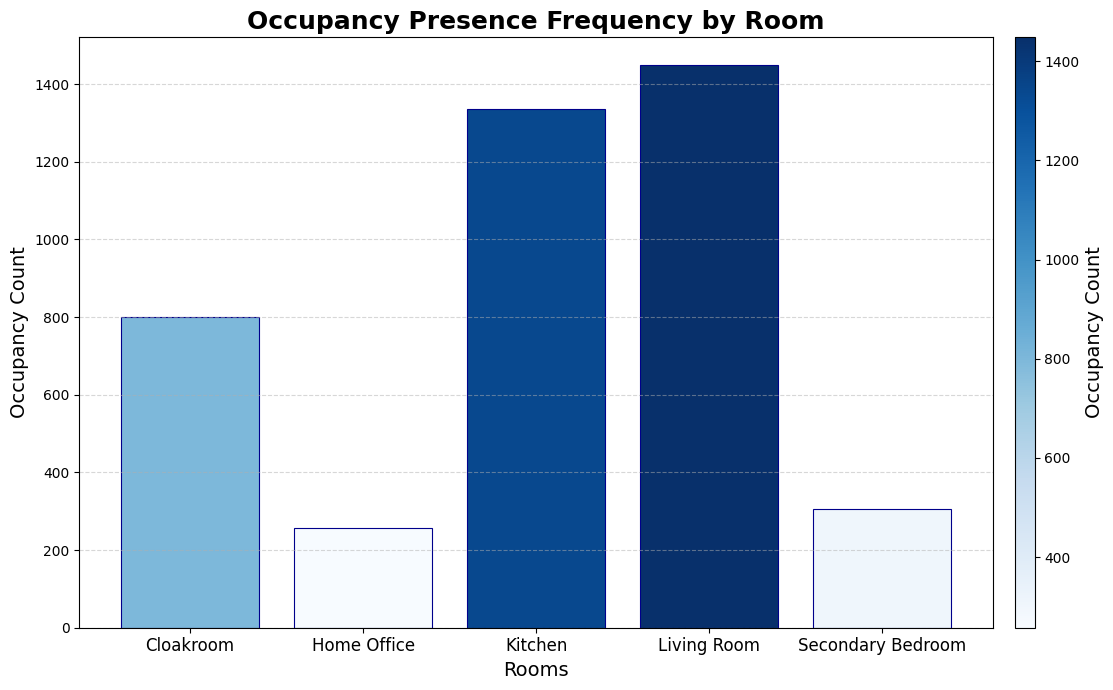

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# İşgal frekanslarını ve oda isimlerini tanımla
occupancy_counts = [room['occupancy presence (0/1)'].sum() for room in rooms]
room_labels = ["Cloakroom", "Home Office", "Kitchen", "Living Room", "Secondary Bedroom"]

# Normalize edilmiş renk skalası
norm = mcolors.Normalize(vmin=min(occupancy_counts), vmax=max(occupancy_counts))
colors = cm.Blues(norm(occupancy_counts))

# Şekil boyutu ve bar grafiği
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(room_labels, occupancy_counts, color=colors, edgecolor='darkblue', linewidth=0.8)

# Başlık ve eksen etiketleri
ax.set_title('Occupancy Presence Frequency by Room', fontsize=18, fontweight='bold')
ax.set_xlabel('Rooms', fontsize=14)
ax.set_ylabel('Occupancy Count', fontsize=14)
ax.set_xticklabels(room_labels, fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Renk skalası açıklaması (Colorbar)
sm = cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])  # Colorbar için gerekli tanımlama
cbar = fig.colorbar(sm, ax=ax, aspect=30, pad=0.02)
cbar.set_label('Occupancy Count', fontsize=14)

# Daha estetik bir tasarım için çizim alanını ayarla
plt.tight_layout()

# Grafiği göster
plt.show()


##Data Visualization
* Plot `temperature` for 10 days in living room

In [ ]:
# Moving Averages Function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotMovingAverage(series, window, plot_average=False ,plot_intervals=False, scale=1.96, plot_anomalies=False):

  """
      series - dataframe with timeseries
      window - rolling window size
      plot_average - show moving average
      plot_intervals - show confidence intervals
      plot_anomalies - show anomalies
  """
  plt.figure(figsize=(25,5))

  rolling_mean = series.rolling(window=window).mean()

  if plot_average:
    plt.title("Moving average with window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

  if not plot_average:
    plt.title("Window size = {}".format(window))

  # Plot confidence intervals for smoothed values
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")

    # Having the intervals, find abnormal values
    if plot_anomalies:
      series_df = pd.DataFrame(series)
      anomalies = pd.DataFrame(index=series_df.index, columns= series_df.columns)
      anomalies[series < lower_bond] = series_df[series < lower_bond]
      anomalies[series > upper_bond] = series_df[series > upper_bond]
      plt.plot(anomalies, "ro", markersize=10, label="Anomalies")

  plt.plot(series[window:], label="Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)


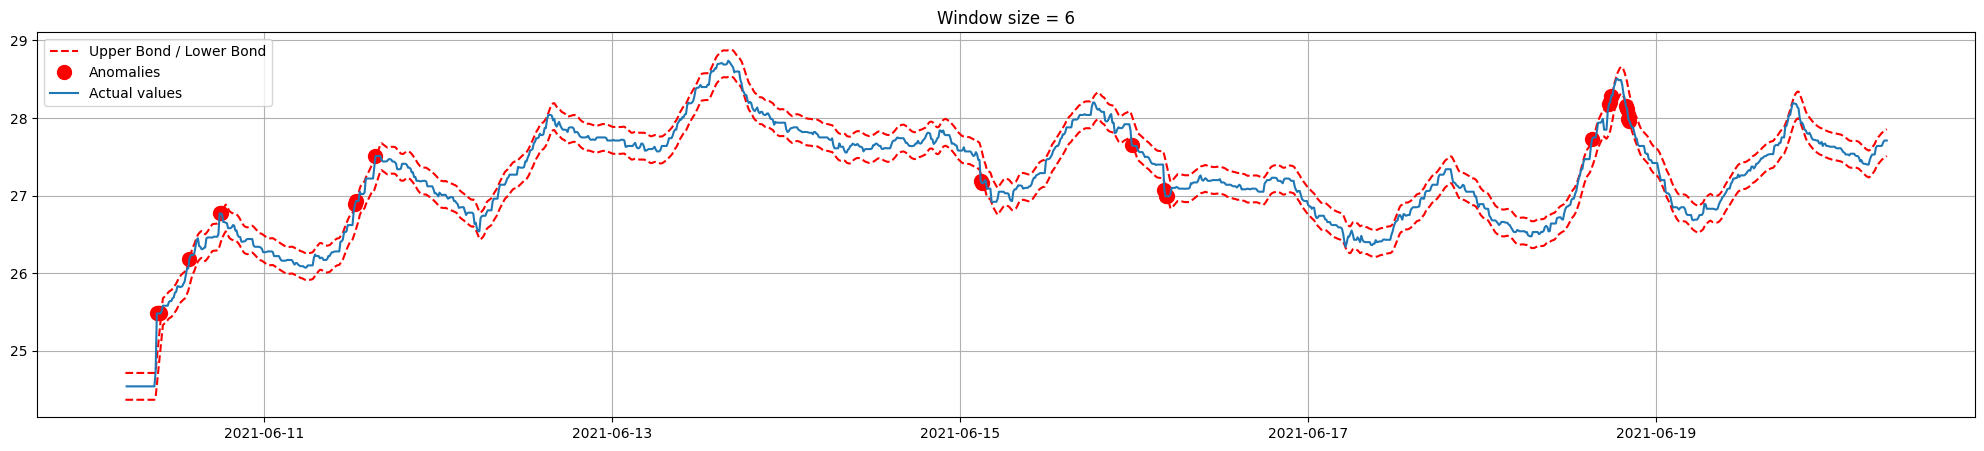

In [ ]:
n_samples = len(rooms[3]['dry-bulb temperature (°C)_x'])//36 # 10 day interval
# Plot with Anomaly detection
plotMovingAverage(rooms[3]['dry-bulb temperature (°C)_x'][n_samples:2*n_samples], window=6,plot_intervals=True, plot_anomalies=True)

## Feature Engineering
* Add information sessions(winter,spring,summer,autumn)
* Visualize correlation matrix

In [ ]:
for i, room in enumerate(rooms):
  seasion_info = np.zeros(len(rooms[i])) # winter 0 ; spring 1 ; summer 2; autumn 3
  var_seasion = 0
  for row in range(len(seasion_info)):
    if 13176 >var_seasion:
      seasion_info[row] = 2
    if 26353 >var_seasion >=13176:
      seasion_info[row] = 3
    if var_seasion >=39529:
      seasion_info[row] = 1
    var_seasion +=1
  rooms[i]['seasion info'] = seasion_info

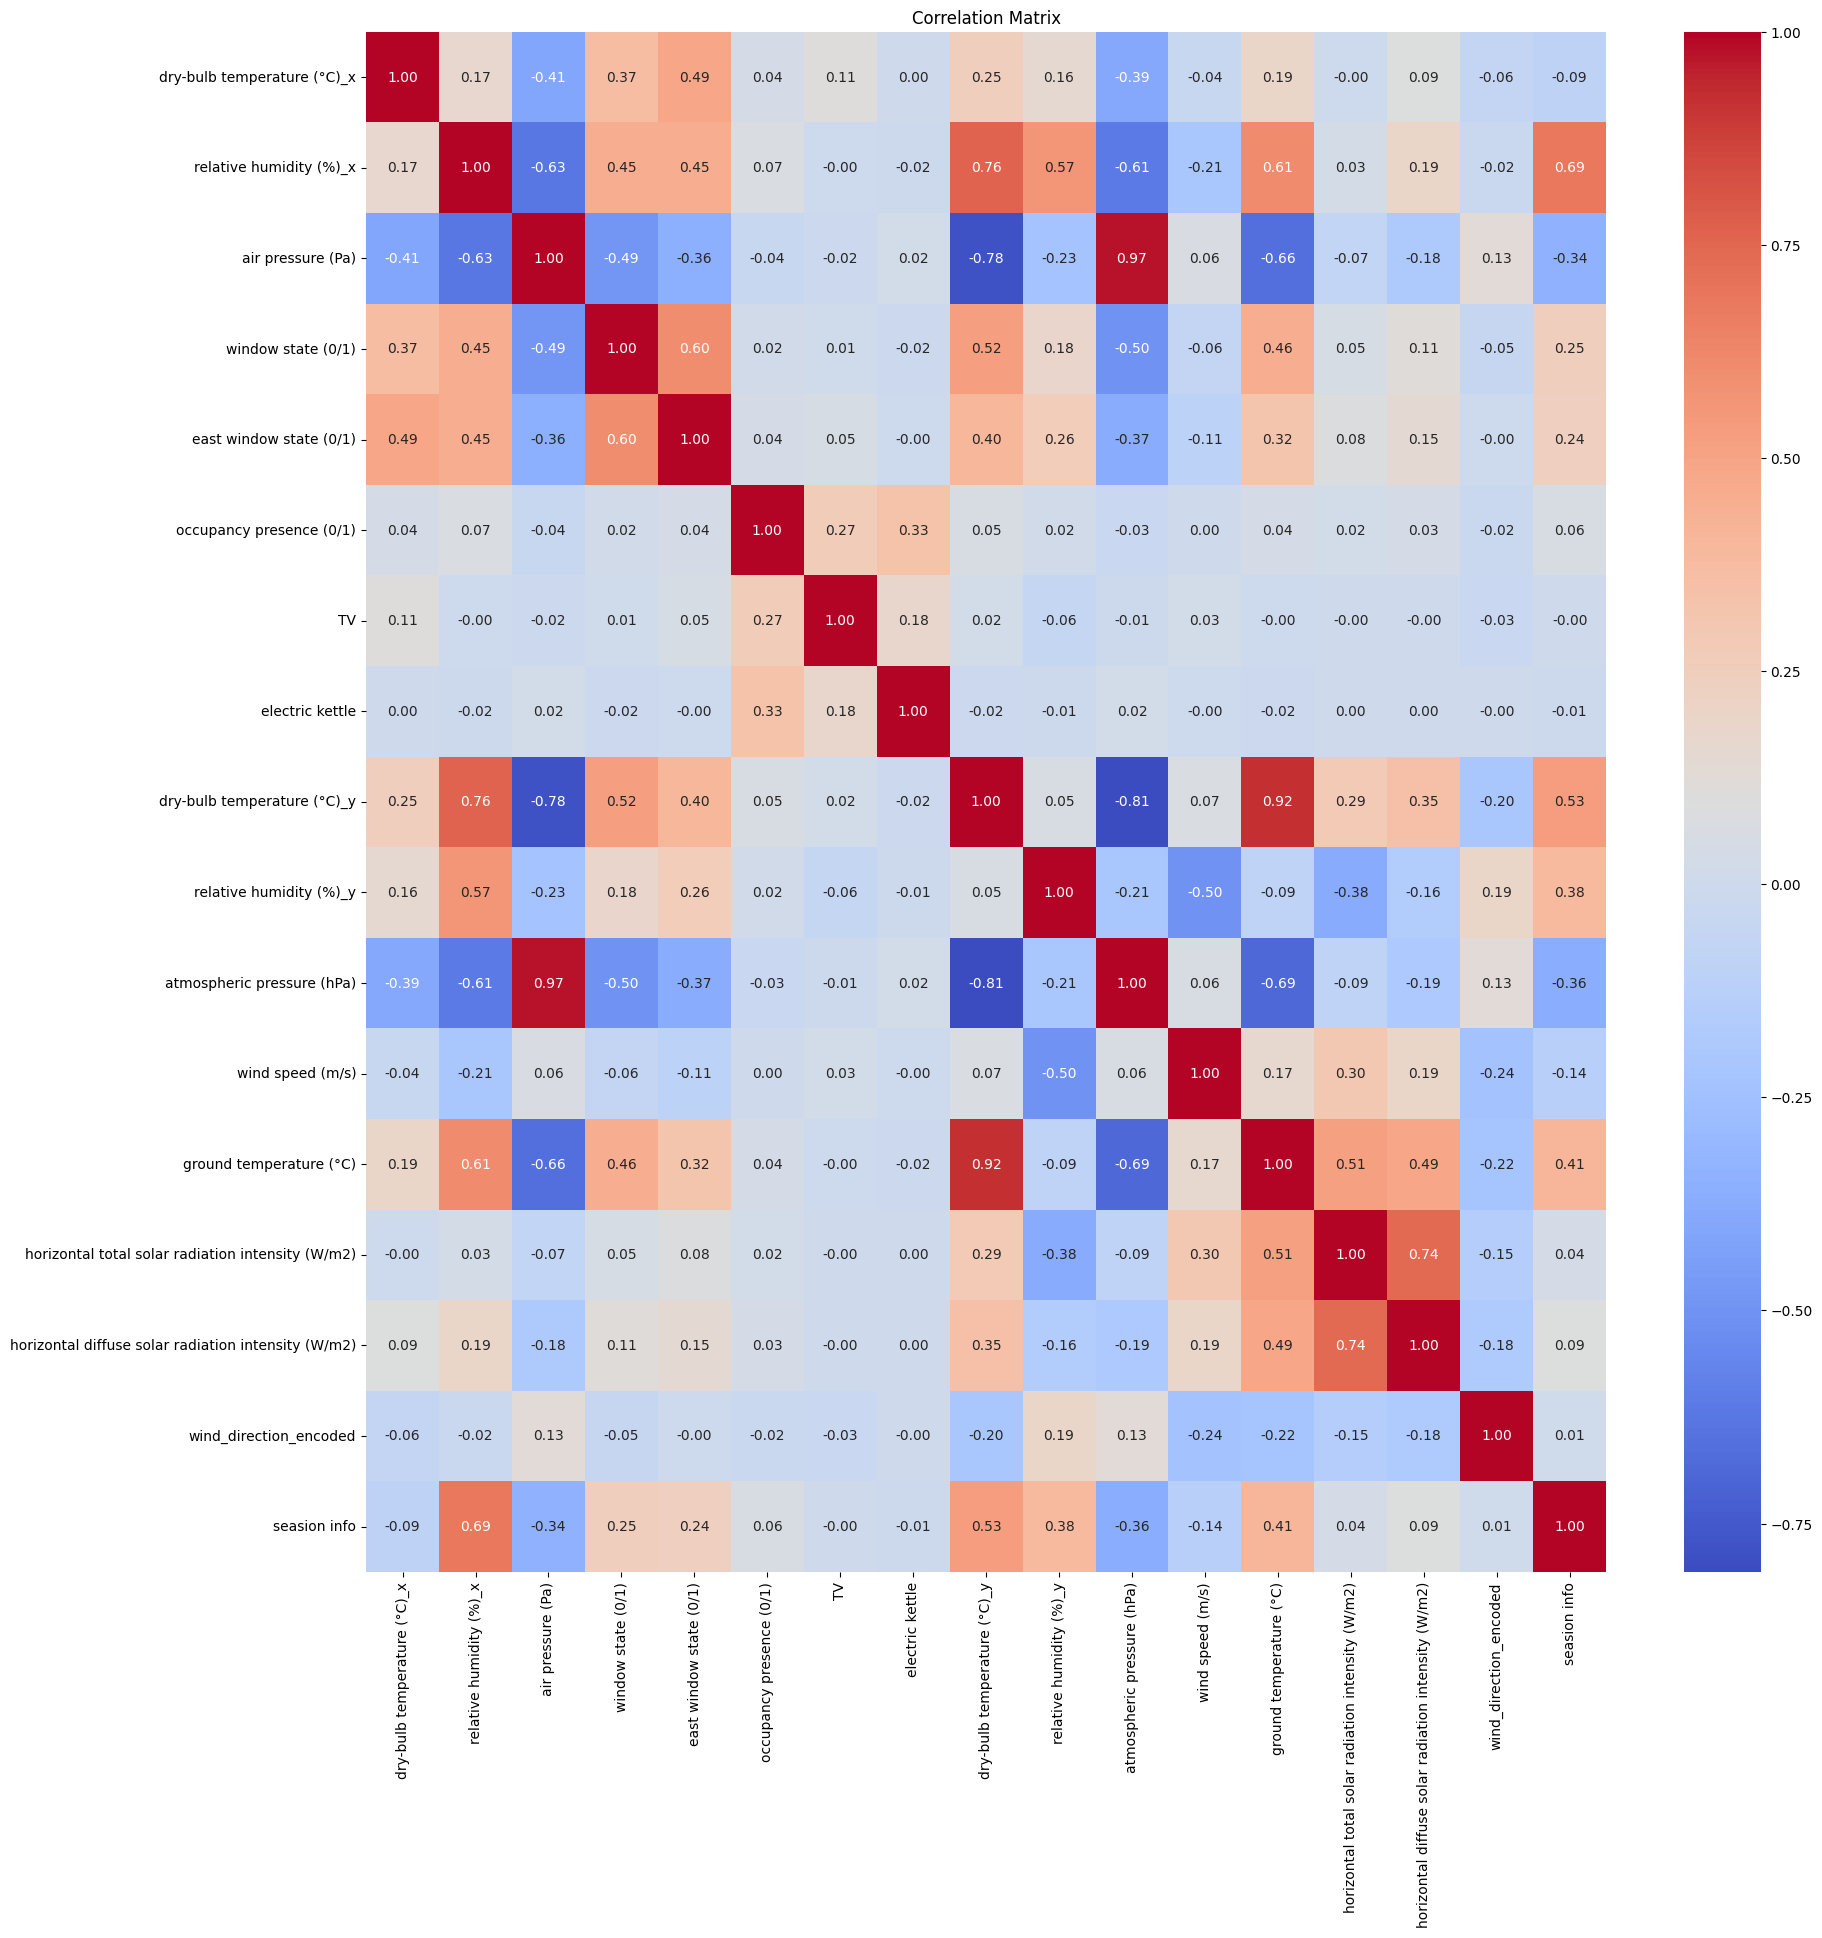

In [ ]:
# Visualize database correlation
def plotCorrelation(data):
  correlation_matrix = data.corr()

  plt.figure(figsize=(20, 20))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title('Correlation Matrix')
  plt.show()
plotCorrelation(rooms[3])

In [ ]:
# İlk olarak veriyi bölümlere ayıralım
train_split_idx = int(len(rooms[3]) * 0.7)  # %70 eğitim
val_split_idx = train_split_idx + int(len(rooms[3]) * 0.15)  # %15 doğrulama

# Her oda için veri setlerini ve scalerları saklayacak yapılar
room_scalers = [{} for _ in range(len(rooms))]
# Normalize edilmemiş orijinal verileri saklayın
rooms_original_split = []

# Her oda için verileri bölün
for i, room in enumerate(rooms):
    # Veriyi kronolojik olarak bölme
    train_data = room.iloc[:train_split_idx].copy()
    val_data = room.iloc[train_split_idx:val_split_idx].copy()
    test_data = room.iloc[val_split_idx:].copy()

    # Veri setlerini kaydet
    rooms_original_split.append({
        'train': train_data,
        'val': val_data,
        'test': test_data
    })

    # Her kolon için ayrı scaler oluştur ve sadece train verisi ile fit et
    for column in room.columns:
        # Her kolon için yeni bir scaler
        scaler = MinMaxScaler()

        # Scaler'ı SADECE eğitim verisi ile fit et
        train_data_2d = train_data[column].values.reshape(-1, 1)
        scaler.fit(train_data_2d)

        # Eğitim verisine transform uygula
        train_data[column] = scaler.transform(train_data_2d)

        # Aynı scaler'ı doğrulama ve test verilerine de uygula (fit etmeden)
        val_data_2d = val_data[column].values.reshape(-1, 1)
        val_data[column] = scaler.transform(val_data_2d)

        test_data_2d = test_data[column].values.reshape(-1, 1)
        test_data[column] = scaler.transform(test_data_2d)

        # Scaler'ı daha sonra kullanmak üzere sakla
        room_scalers[i][column] = scaler

    # Normalize edilmiş verileri rooms listesini güncelle
    rooms[i] = pd.concat([train_data, val_data, test_data])

## Generators and Model Constructioning
* Data Preprations according to correlation matrix
* Create Generators
* Model Constructing
* Create a function `finish` all tasks

In [ ]:

# Arrange temperature dataset
try:
  temp_columns =['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                'air pressure (Pa)', 'window state (0/1)','east window state (0/1)',
                'occupancy presence (0/1)', 'TV','wind speed (m/s)',
                'dry-bulb temperature (°C)_y']
  temp_data = [rooms[i][temp_columns] for i in range(len(rooms))]
except:
  temp_columns =['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                'air pressure (Pa)', 'wind speed (m/s)',
                'occupancy presence (0/1)', 'dry-bulb temperature (°C)_y']
  temp_data = [rooms[i][temp_columns] for i in range(len(rooms))]
# Arrange Humidity dataset
try:
  humidity_columns = ['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                    'air pressure (Pa)', 'window state (0/1)',
                    'occupancy presence (0/1)','seasion info',
                    'dry-bulb temperature (°C)_y', 'relative humidity (%)_y',
                    'wind speed (m/s)']
  humidity_data = [rooms[i][humidity_columns] for i in range(len(rooms))]
except:
  humidity_columns = ['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                    'air pressure (Pa)', 'relative humidity (%)_y',
                    'occupancy presence (0/1)','seasion info',
                    'dry-bulb temperature (°C)_y', 'wind speed (m/s)']
  humidity_data = [rooms[i][humidity_columns] for i in range(len(rooms))]
# Arrange Pressure dataset
pressure_columns = ['dry-bulb temperature (°C)_x', 'relative humidity (%)_x',
                    'air pressure (Pa)','wind speed (m/s)','wind_direction_encoded',
                    'occupancy presence (0/1)', 'relative humidity (%)_y',
                    'dry-bulb temperature (°C)_y','horizontal diffuse solar radiation intensity (W/m2)']
pressure_data = [rooms[i][pressure_columns] for i in range(len(rooms))]


In [ ]:
# Generator function
def test_generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6,column_number=0):

  if max_index is None:
    max_index = len(data)- delay- 1

  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)

    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j]- lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][column_number]
    return samples, targets

def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6, column_number=0):

  if max_index is None:
    max_index = len(data)- delay- 1

  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)

    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j]- lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][column_number]
    yield samples, targets

In [ ]:
# Create Generators
lookback = 1140 #  10 day
step = 3 # 30 minutes interval
delay = 144 # 1 day
batch_size = 128

train_gen_list = [[],[],[],[],[]]
val_gen_list = [[],[],[],[],[]]
test_gen_list = [[],[],[],[],[]]

train_split = len(rooms[3])*70//100
val_split = train_split + len(rooms[3])*15//100

val_steps = (val_split- train_split- 1 - lookback)
test_steps = (len(rooms[3])- val_split-1 - lookback)

#Train generators
def get_train_gen(data,column_number,room_number):
  train_gen = generator(data.to_numpy(),
                          lookback=lookback,
                          delay=delay,
                          min_index=0,
                          max_index=train_split,
                          shuffle=True,
                          step=step,
                          batch_size=batch_size,
                          column_number=column_number)
  train_gen_list[room_number].append(train_gen)

# Validation generators
def get_val_gen(data,column_number,room_number):
  val_gen = generator(data.to_numpy(),
                          lookback=lookback,
                          delay=delay,
                          min_index=train_split+1,
                          max_index=val_split,
                          step=step,
                          batch_size=batch_size,
                          column_number=column_number)
  val_gen_list[room_number].append(val_gen)

# Test Generators
def get_test_gen(data,column_number,room_number):
  test_gen = test_generator(data.to_numpy(),
                          lookback=lookback,
                          delay=delay,
                          min_index=val_split+1,
                          max_index=None,
                          step=step,
                          batch_size=61*batch_size,
                          column_number=column_number)
  test_gen_list[room_number].append(test_gen)

# Bölme indekslerini güncelle
train_split = train_split_idx
val_split = val_split_idx

# Generator çağrılarınız aynı kalabilir
for i in range(len(rooms)):
  get_train_gen(temp_data[i], 0, i)
  get_train_gen(humidity_data[i], 1, i)
  get_train_gen(pressure_data[i], 2, i)

  get_val_gen(temp_data[i], 0, i)
  get_val_gen(humidity_data[i], 1, i)
  get_val_gen(pressure_data[i], 2, i)

  get_test_gen(temp_data[i], 0, i)
  get_test_gen(humidity_data[i], 1, i)
  get_test_gen(pressure_data[i], 2, i)

In [ ]:
# Model function
def build_model(model_name,shape, isAlternative=False):

  model = Sequential()

  if model_name =='LSTM':
    model.add(layers.LSTM(20,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LSTM(10,return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

  elif model_name =='GRU' and not isAlternative:
    model.add(layers.GRU(25,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.GRU(13,return_sequences=False,kernel_regularizer=regularizers.l2(0.01)))

  elif model_name =='GRU' and isAlternative:
    model.add(layers.GRU(20,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.GRU(10,return_sequences=False))

  elif model_name == 'BiGRU'and isAlternative:
    model.add(layers.Bidirectional(layers.GRU(20,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01))))
    model.add(layers.Bidirectional(layers.GRU(10,return_sequences=False,kernel_regularizer=regularizers.l2(0.01))))

  elif model_name == 'BiGRU'and not isAlternative:
    model.add(layers.Bidirectional(layers.GRU(25,return_sequences=True, input_shape=(None, shape),kernel_regularizer=regularizers.l2(0.01))))
    model.add(layers.Bidirectional(layers.GRU(13,return_sequences=False,kernel_regularizer=regularizers.l2(0.01))))

  model.add(layers.Dense(1))

  return model

In [ ]:
# Pass GPU devices
device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print("Device available for TensorFlow usage:",device)

Device available for TensorFlow usage: GPU


In [ ]:
callbacks_list = [
                  keras.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  factor=0.1,
                  patience=1,
                  ),
                  ]

In [ ]:
def min_max_assigner(room_number):
  room = rooms_original[room_number]
  min_value_temp = room['dry-bulb temperature (°C)'].min()
  max_value_temp = room['dry-bulb temperature (°C)'].max()
  min_value_humidity = room['relative humidity (%)'].min()
  max_value_humidity = room['relative humidity (%)'].max()
  min_value_pressure = room['air pressure (Pa)'].min()
  max_value_pressure = room['air pressure (Pa)'].max()
  return [min_value_temp, max_value_temp, min_value_humidity, max_value_humidity, min_value_pressure, max_value_pressure]

In [ ]:
def assign_model(model_name,data,room_number,isAlternative=False):
  if isAlternative:
    model = build_model(model_name=model_name, shape=data[room_number].shape[-1],isAlternative=True)
  else:
    model = build_model(model_name=model_name, shape=data[room_number].shape[-1],isAlternative=False)
  return model

In [ ]:
def compile_model(model):
  model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
def train_model(model,room_number,attr):
  history = model.fit(train_gen_list[room_number][attr],
                                steps_per_epoch=500,
                                epochs=10,
                                validation_data= val_gen_list[room_number][attr],
                                callbacks=callbacks_list,
                                validation_steps=val_steps)
  return history

In [ ]:
def prediction_scaler(original, predictions, room_number, attr, column_name):
    # Kaydedilen scaler'ı kullan
    scaler = room_scalers[room_number][column_name]

    # Normalize edilmiş tahminleri 2D diziye dönüştür
    predictions_2d = predictions.reshape(-1, 1)

    # Ters ölçeklendirme (inverse_transform)
    unscaled_predictions = scaler.inverse_transform(predictions_2d)

    # Orijinal verileri de ters ölçeklendir
    original_2d = original.reshape(-1, 1)
    unscaled_original = scaler.inverse_transform(original_2d)

    return unscaled_predictions, unscaled_original

In [ ]:
def visualize_loss(history,attr,room_number):
  room_dict={
      0: 'Cloakroom',
      1: 'Home Office',
      2: 'Kitchen',
      3: 'Living Room',
      4: 'Secondary Bedroom'
  }
  print()
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(10,4))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'go', label='Validation Loss')
  plt.title(f'{room_dict[room_number]} {attr} Training and Validation Loss')
  plt.legend()
  plt.show()

In [ ]:
def visualize_mae(history,attr,room_number):
  room_dict={
      0: 'Cloakroom',
      1: 'Home Office',
      2: 'Kitchen',
      3: 'Living Room',
      4: 'Secondary Bedroom'
  }
  print()
  mae = history.history['mae']
  val_mae = history.history['val_mae']
  epochs = range(1, len(mae) + 1)
  plt.figure(figsize=(10,4))
  plt.plot(epochs, mae, 'b', label='Training MAE')
  plt.plot(epochs, val_mae, 'go', label='Validation MAE')
  plt.title(f'{room_dict[room_number]} {attr} Training and validation MAE')
  plt.legend()
  plt.show()

In [ ]:
def plot_results(original,predictions,model_name,room_number,attr):

  # Room names
  room_dict={
      0: 'Cloakroom',
      1: 'Home Office',
      2: 'Kitchen',
      3: 'Living Room',
      4: 'Secondary Bedroom'
  }
  print()
  plt.figure(figsize=(10,4))
  plt.plot(original[:-144:], color='blue', label='Original Value')
  plt.plot(predictions[144:,0][::] , color='green', label='Predicted Value')
  plt.title(f'{room_dict[room_number]} {attr} Prediction {model_name}')
  plt.xlabel('from 15 April 00:00 - 29 May  00:00 with 10 minutes interval')
  plt.ylabel(attr)
  plt.legend()
  plt.show()

In [ ]:
def calculate_metrics(original,predictions,room_number,attr):
  mae = mean_absolute_error(original, predictions)
  mse = mean_squared_error(original, predictions)
  rmse = np.sqrt(np.mean((original-predictions)**2))
  print()
  print(f'{attr}')
  print('MAE: %.3f' % mae)
  print('MSE: %.3f' % mse)
  print('RMSE: %.3f' % rmse)

In [ ]:
def finish(model_name,room_number):

  #Buid model
  model_temp = assign_model(model_name, temp_data,room_number,isAlternative=False)
  model_humiditiy = assign_model(model_name, humidity_data,room_number,isAlternative=True)
  model_pressure = assign_model(model_name, pressure_data,room_number,isAlternative=True)
  print(model_temp.summary())
  print(model_humiditiy.summary())
  print(model_pressure.summary())
  # Compile model
  compile_model(model_temp)
  compile_model(model_humiditiy)
  compile_model(model_pressure)

  # Train models
  history_temp = train_model(model_temp,room_number,0)
  history_humidity = train_model(model_humiditiy,room_number,1)
  history_pressure = train_model(model_pressure,room_number,2)

  # Visualize Loss
  visualize_loss(history_temp,'dry-bulb temperature (°C)',room_number)
  visualize_loss(history_humidity,'relative humidity (%)',room_number)
  visualize_loss(history_pressure,'atmospheric pressure (hPa)',room_number)

  # Visualize Mae
  visualize_mae(history_temp,'dry-bulb temperature (°C)',room_number)
  visualize_mae(history_humidity,'relative humidity (%)',room_number)
  visualize_mae(history_pressure,'atmospheric pressure (hPa)',room_number)


  # Save model
  model_save_path = '/content/drive/MyDrive/smart_home_project.keras'
  tf.keras.models.save_model(model_temp, model_save_path)
  tf.keras.models.save_model(model_humiditiy, model_save_path)
  tf.keras.models.save_model(model_pressure, model_save_path)

  # Predict values
  predictions_temp = model_temp.predict(test_gen_list[room_number][0][0])
  predictions_humidity = model_humiditiy.predict(test_gen_list[room_number][1][0])
  predictions_pressure = model_pressure.predict(test_gen_list[room_number][2][0])

  #Scale values
  min_value_temp, max_value_temp, min_value_humidity, max_value_humidity, min_value_pressure, max_value_pressure = min_max_assigner(room_number)

  # Tahminleri ve gerçek değerleri ters ölçeklendirin
  predictions_temp, original_temp = prediction_scaler(
      test_gen_list[room_number][0][1],
      predictions_temp,
      room_number,
      'dry-bulb temperature (°C)',
      'dry-bulb temperature (°C)_x'  # Kullanılan kolon adı
  )

  predictions_humidity, original_humidity = prediction_scaler(
      test_gen_list[room_number][1][1],
      predictions_humidity,
      room_number,
      'relative humidity (%)',
      'relative humidity (%)_x'  # Kullanılan kolon adı
  )

  predictions_pressure, original_pressure = prediction_scaler(
      test_gen_list[room_number][2][1],
      predictions_pressure,
      room_number,
      'air pressure (Pa)',
      'air pressure (Pa)'  # Kullanılan kolon adı
  )

  #Plot Results

  plot_results(original_temp,predictions_temp,model_name,room_number,attr='dry-bulb temperature (°C)')
  plot_results(original_humidity,predictions_humidity,model_name,room_number,attr='relative humidity (%)')
  plot_results(original_pressure,predictions_pressure,model_name,room_number,attr='atmospheric pressure (hPa)')

  #Calculate Metrics
  calculate_metrics(original_temp,predictions_temp,room_number,attr='dry-bulb temperature (°C)')
  calculate_metrics(original_humidity,predictions_humidity,room_number,attr='relative humidity (%)')
  calculate_metrics(original_pressure,predictions_pressure,room_number,attr='atmospheric pressure (hPa)')

  # Store predictions into csv file
  df_temp = pd.DataFrame(predictions_temp)
  df_humidity = pd.DataFrame(predictions_humidity)
  df_pressure = pd.DataFrame(predictions_pressure)
  df = pd.concat([df_temp,df_humidity,df_pressure],axis=1)
  df.to_csv(f'predictions{room_number}.csv', index=False)

`NOTE:` I tried LSTM model to compare results with results of GRU model and I decided to apply GRU only because of its performance.

## Room 1 Forecasting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, None, 25)       │         2,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 13)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049 (15.82 KB)

 Trainable params: 4,049 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, None, 20)       │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771 (10.82 KB)

 Trainable params: 2,771 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, None, 20)       │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831 (11.06 KB)

 Trainable params: 2,831 (11.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - loss: 0.2621 - mae: 0.1388 - val_loss: 0.0369 - val_mae: 0.0815 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0246 - mae: 0.0620 - val_loss: 0.0147 - val_mae: 0.0769 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0104 - mae: 0.0623 - val_loss: 0.0105 - val_mae: 0.0737 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 176ms/step - loss: 0.0079 - mae: 0.0610 - val_loss: 0.0112 - val_mae: 0.0780 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 177ms/step - loss: 0.0071 - mae: 0.0593 - val_loss: 0.0111 - val_mae: 0.0775 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0069 - mae: 0.0583 - val_loss: 0.0106 - val_mae: 0.0756 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0071 - mae: 0.0593 - val_loss: 0.0107 - val_mae: 0.0

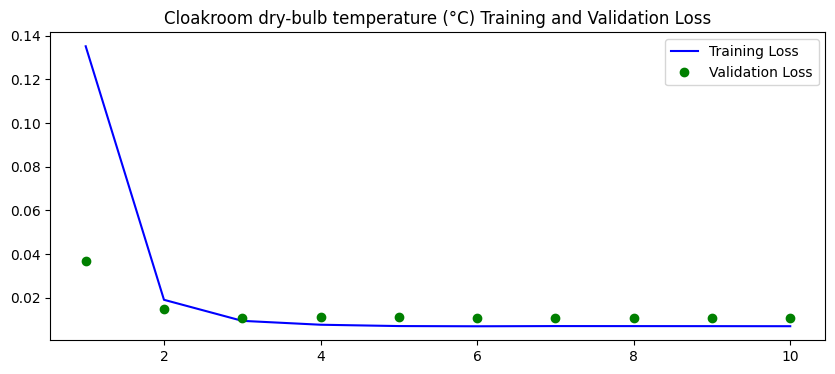

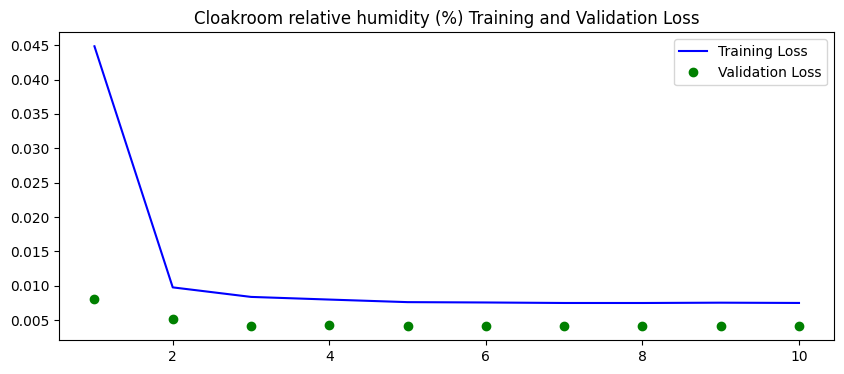

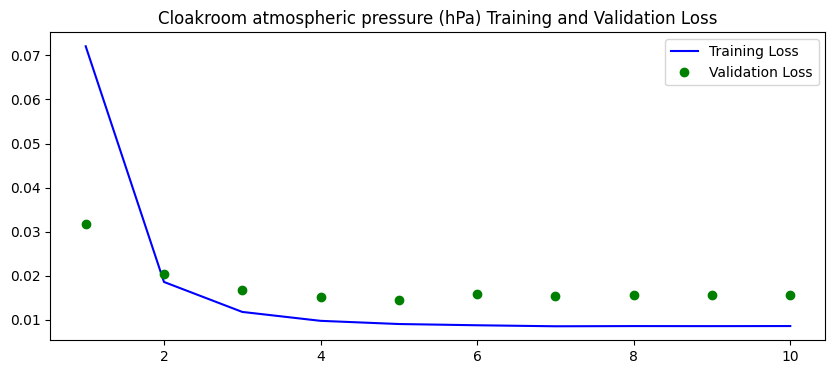

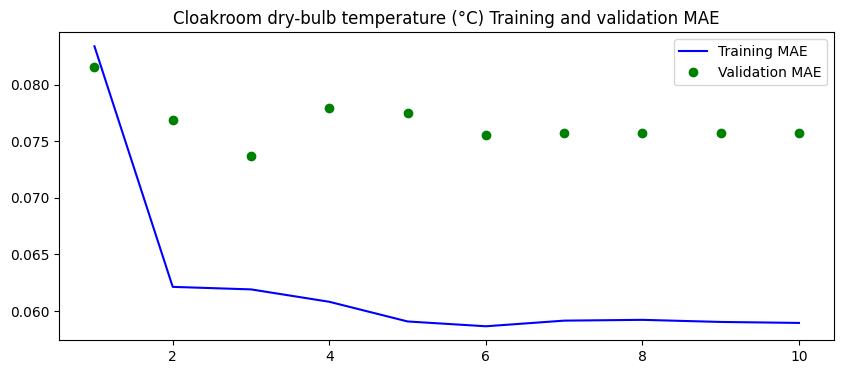

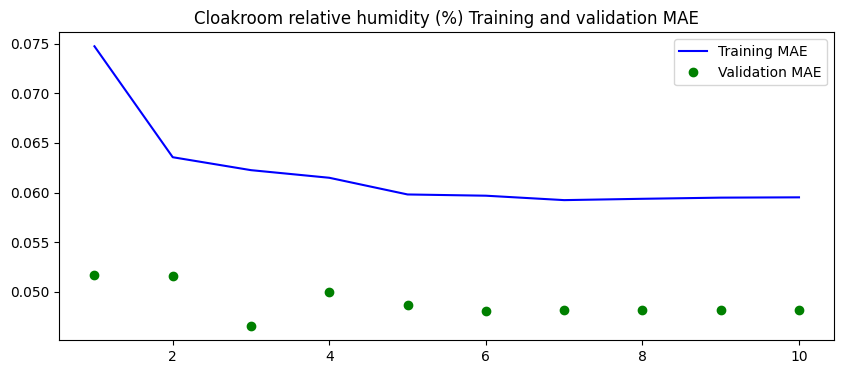

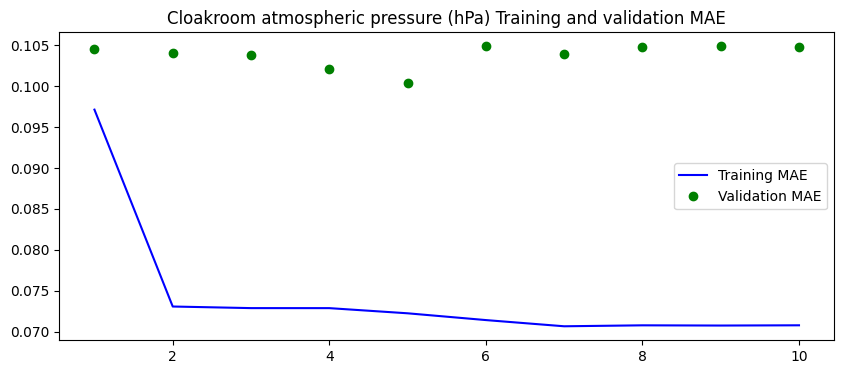

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step



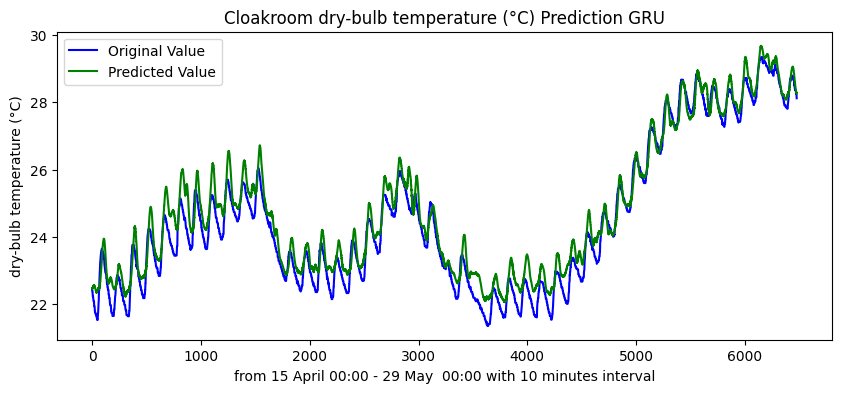

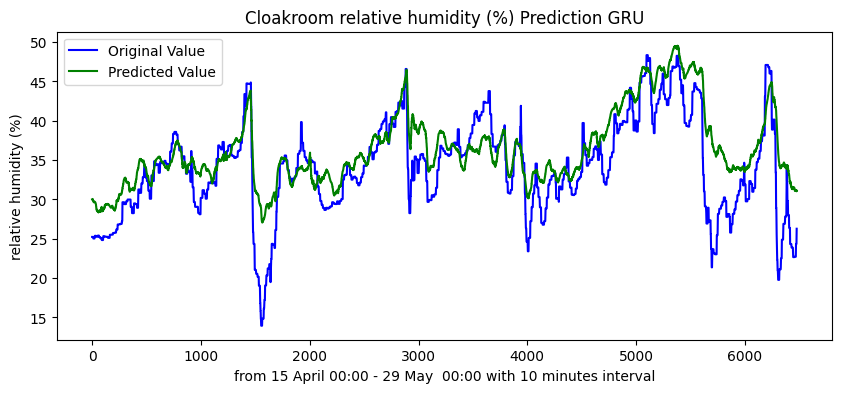

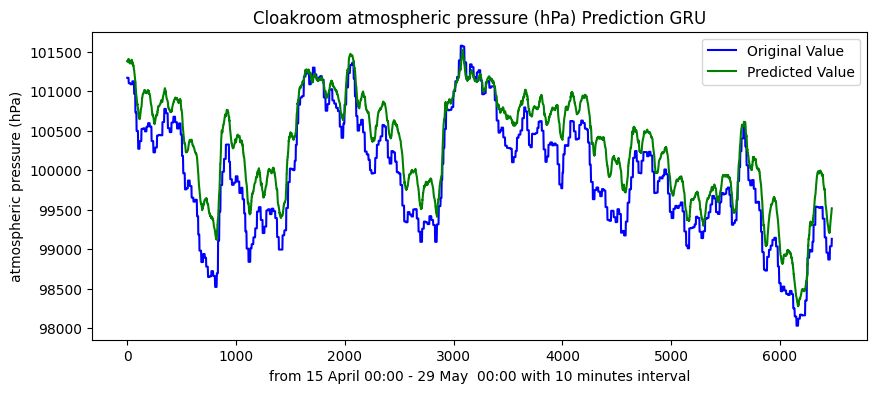


dry-bulb temperature (°C)
MAE: 0.567
MSE: 0.535
RMSE: 0.731

relative humidity (%)
MAE: 4.446
MSE: 43.607
RMSE: 6.604

atmospheric pressure (hPa)
MAE: 599.096
MSE: 504620.703
RMSE: 710.367


In [ ]:
finish(model_name='GRU',room_number=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 20)       │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,411 (13.32 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, None, 20)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571 (13.95 KB)

 Trainable params: 3,571 (13.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, None, 20)       │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,651 (14.26 KB)

 Trainable params: 3,651 (14.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - loss: 0.2322 - mae: 0.1150 - val_loss: 0.0305 - val_mae: 0.0965 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0188 - mae: 0.0679 - val_loss: 0.0188 - val_mae: 0.0974 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0094 - mae: 0.0635 - val_loss: 0.0118 - val_mae: 0.0788 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0073 - mae: 0.0597 - val_loss: 0.0241 - val_mae: 0.1152 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0064 - mae: 0.0565 - val_loss: 0.0241 - val_mae: 0.1164 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0063 - mae: 0.0558 - val_loss: 0.0237 - val_mae: 0.1152 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0062 - mae: 0.0555 - val_loss: 0.0239 - val_mae: 0.1

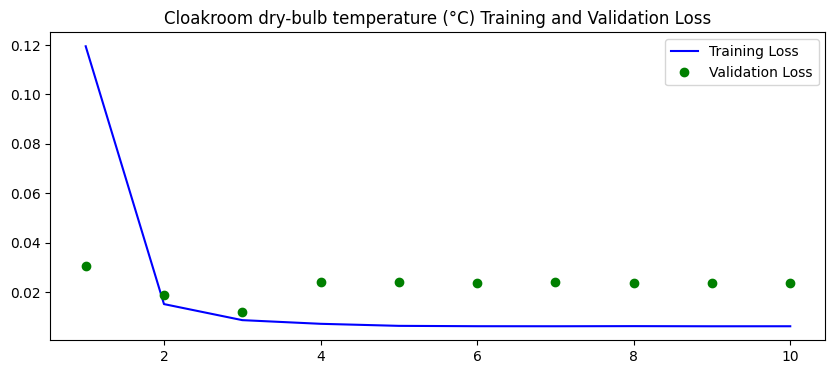

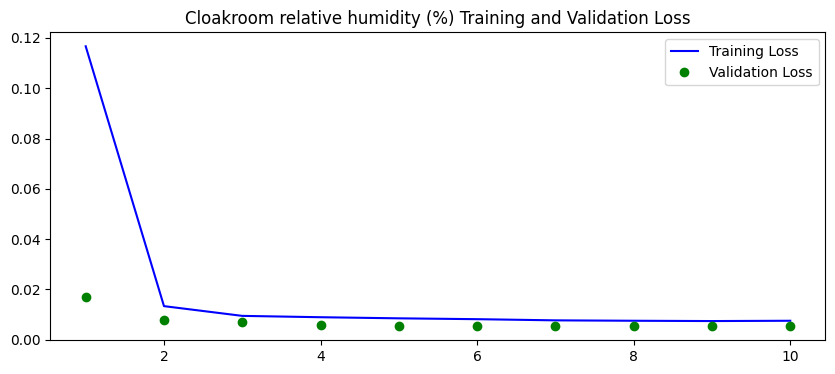

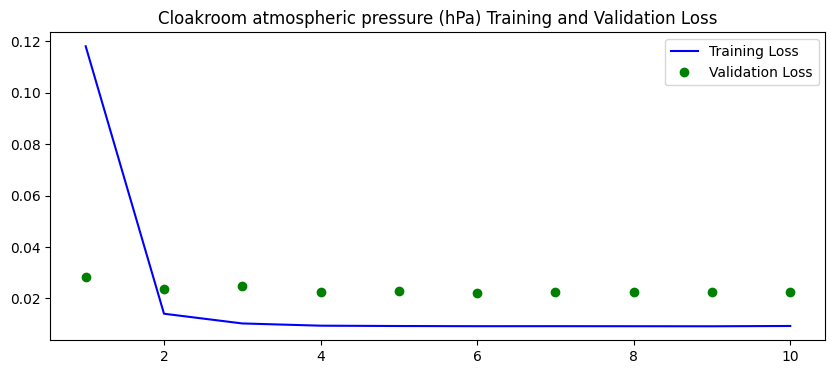

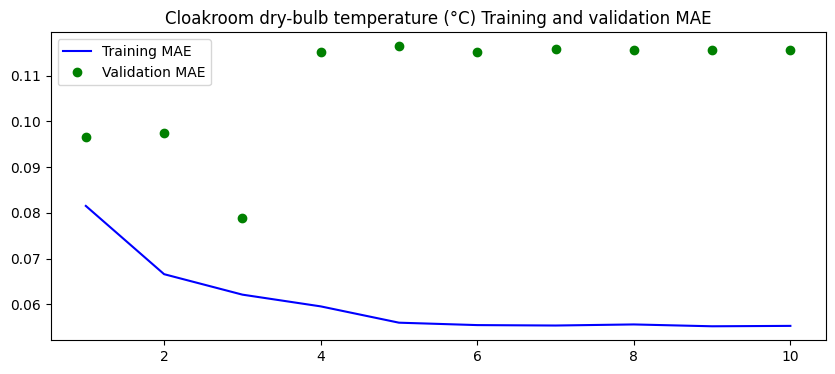

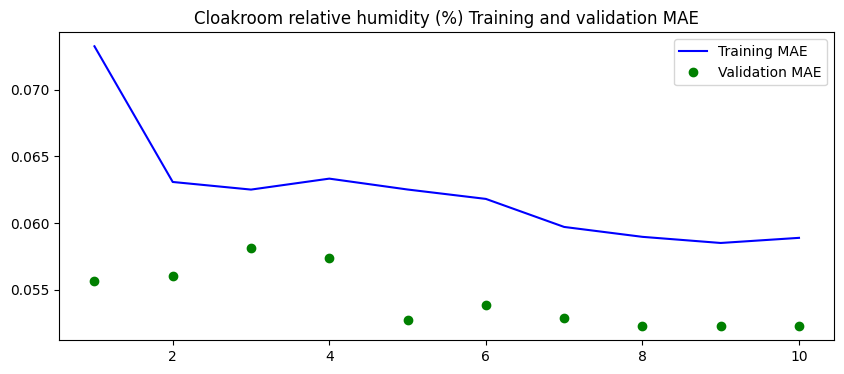

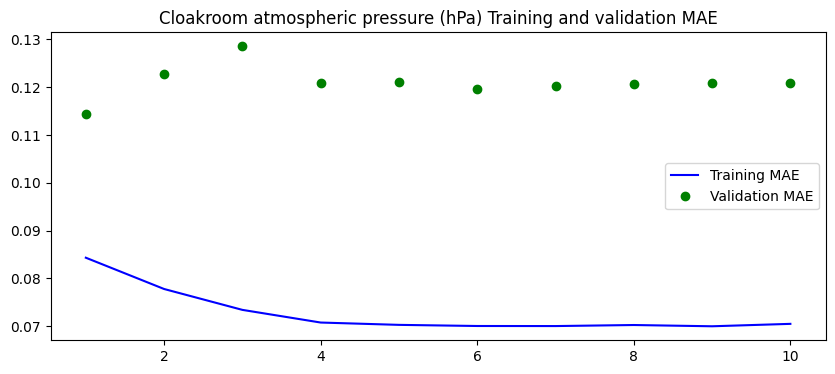

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step



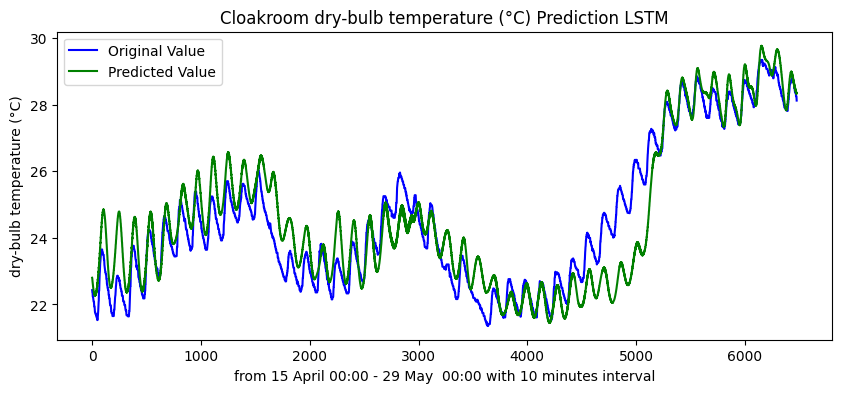

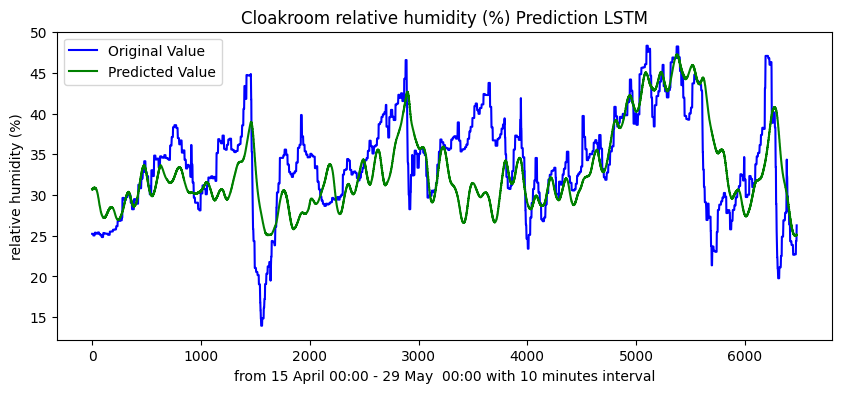

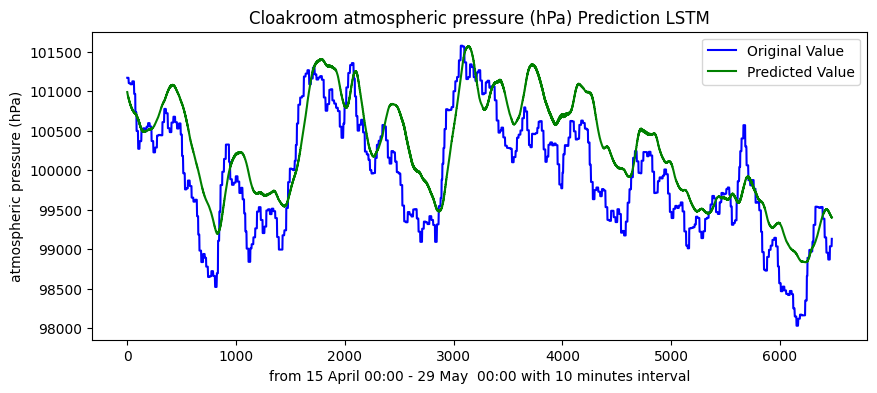


dry-bulb temperature (°C)
MAE: 0.883
MSE: 1.429
RMSE: 1.195

relative humidity (%)
MAE: 5.352
MSE: 48.978
RMSE: 6.998

atmospheric pressure (hPa)
MAE: 632.521
MSE: 600408.004
RMSE: 774.860


In [ ]:
finish(model_name='LSTM',room_number=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 317ms/step - loss: 0.5285 - mae: 0.1195 - val_loss: 0.0372 - val_mae: 0.0912 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0224 - mae: 0.0650 - val_loss: 0.0172 - val_mae: 0.0927 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0097 - mae: 0.0635 - val_loss: 0.0120 - val_mae: 0.0795 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 316ms/step - loss: 0.0078 - mae: 0.0612 - val_loss: 0.0109 - val_mae: 0.0762 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 315ms/step - loss: 0.0073 - mae: 0.0608 - val_loss: 0.0114 - val_mae: 0.0785 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 316ms/step - loss: 0.0065 - mae: 0.0572 - val_loss: 0.0108 - val_mae: 0.0762 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 316ms/step - loss: 0.0065 - mae: 0.0574 - val_loss: 0.0105 - val_mae: 

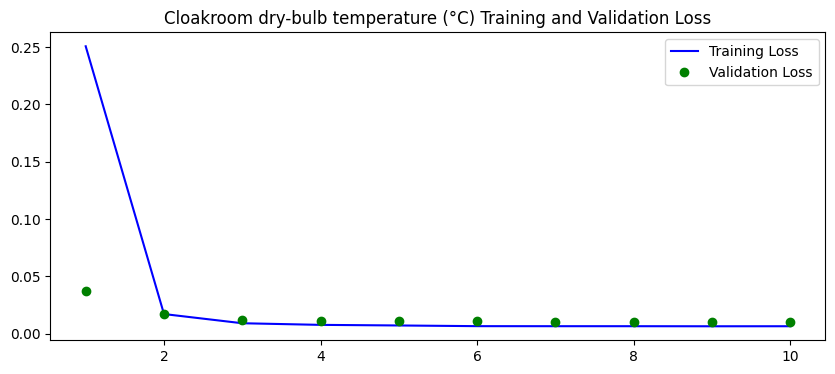

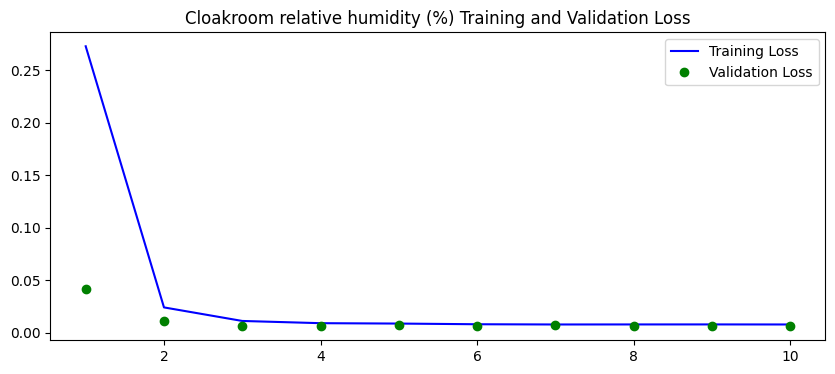

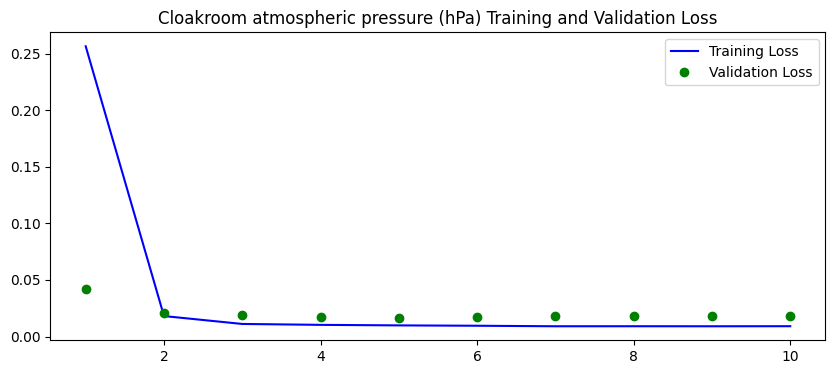

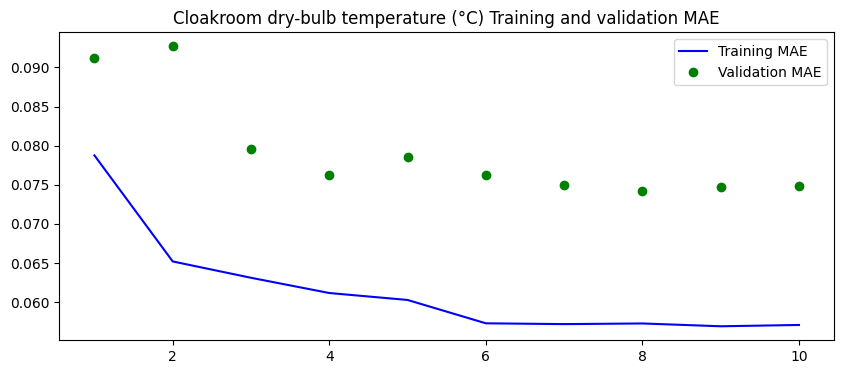

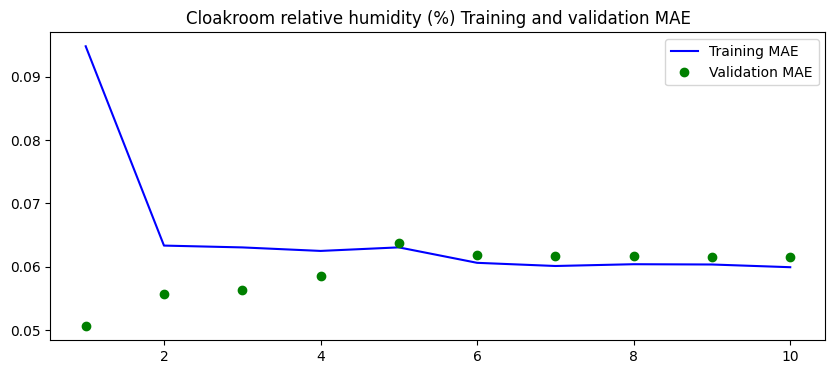

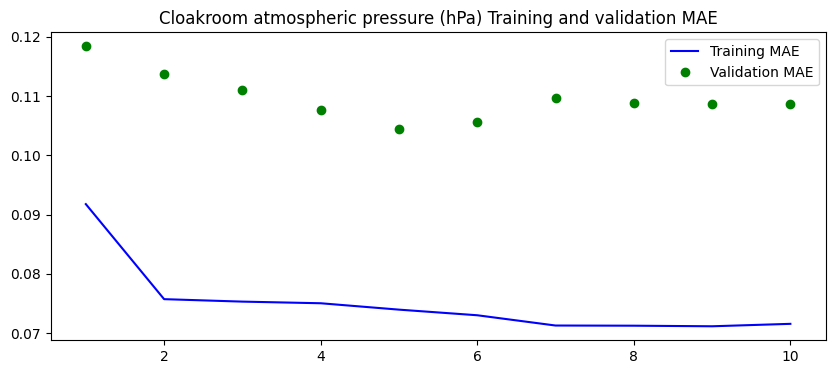

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step



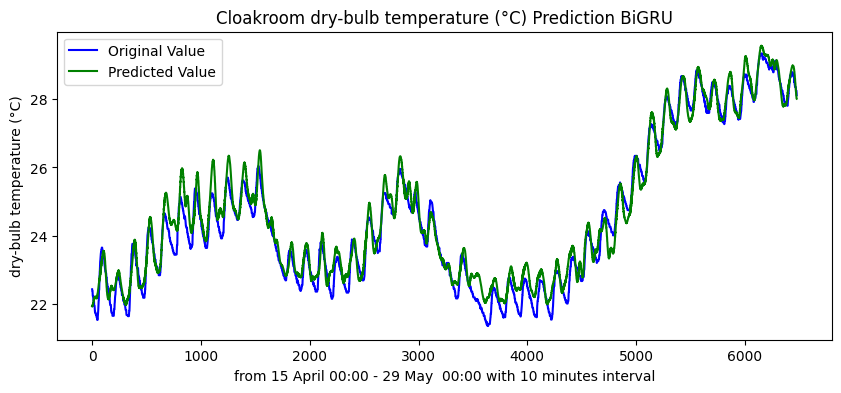

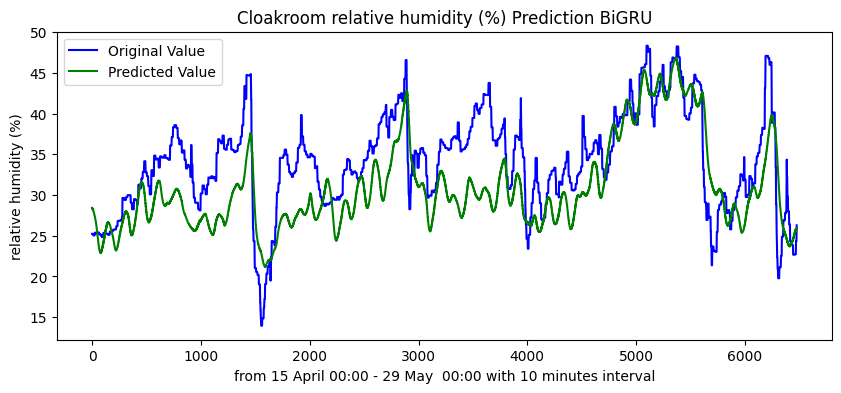

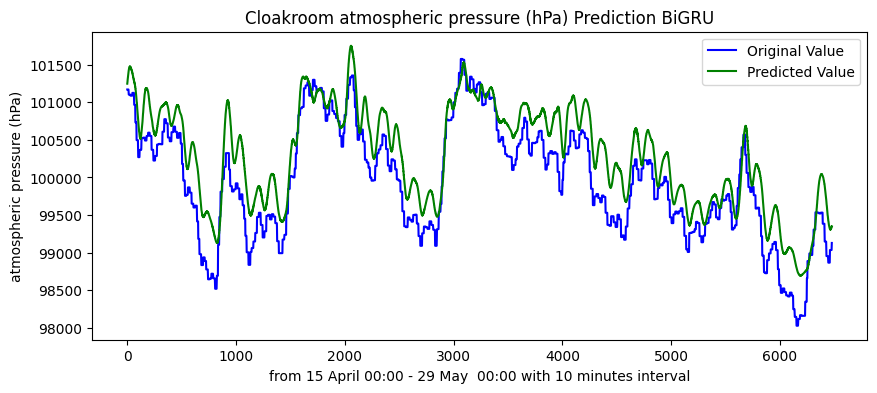


dry-bulb temperature (°C)
MAE: 0.550
MSE: 0.488
RMSE: 0.699

relative humidity (%)
MAE: 5.983
MSE: 53.035
RMSE: 7.283

atmospheric pressure (hPa)
MAE: 612.151
MSE: 543626.912
RMSE: 737.311


In [ ]:
finish(model_name='BiGRU',room_number=0)

## Room 2 Forecasting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, None, 25)       │         2,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 13)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049 (15.82 KB)

 Trainable params: 4,049 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, None, 20)       │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771 (10.82 KB)

 Trainable params: 2,771 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, None, 20)       │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831 (11.06 KB)

 Trainable params: 2,831 (11.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - loss: 0.3368 - mae: 0.1999 - val_loss: 0.0558 - val_mae: 0.1023 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 0.0392 - mae: 0.0645 - val_loss: 0.0267 - val_mae: 0.0991 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 0.0181 - mae: 0.0645 - val_loss: 0.0191 - val_mae: 0.1013 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 181ms/step - loss: 0.0121 - mae: 0.0650 - val_loss: 0.0211 - val_mae: 0.1167 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - loss: 0.0101 - mae: 0.0630 - val_loss: 0.0178 - val_mae: 0.1054 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 182ms/step - loss: 0.0098 - mae: 0.0630 - val_loss: 0.0167 - val_mae: 0.1018 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - loss: 0.0094 - mae: 0.0619 - val_loss: 0.0159 - val_mae: 0.0

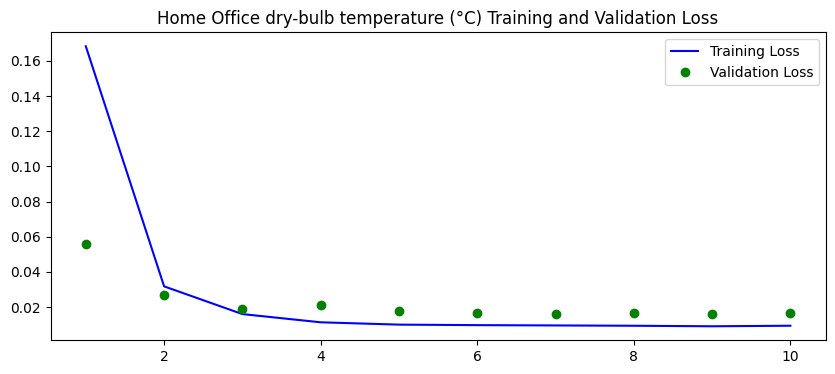

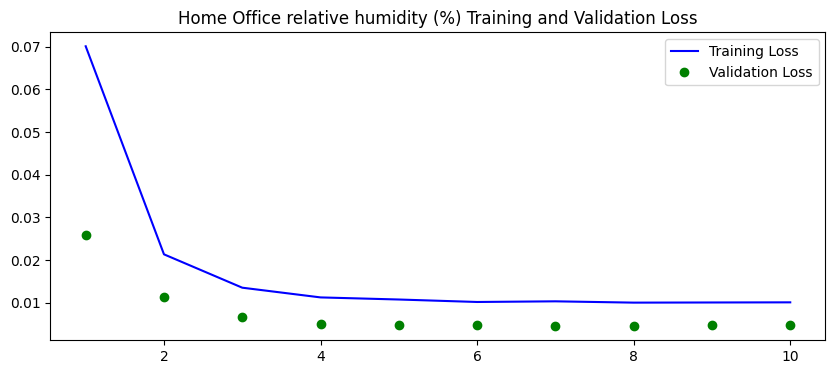

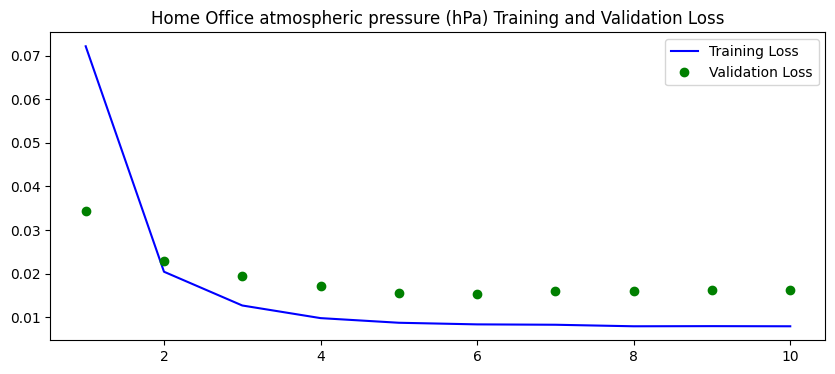

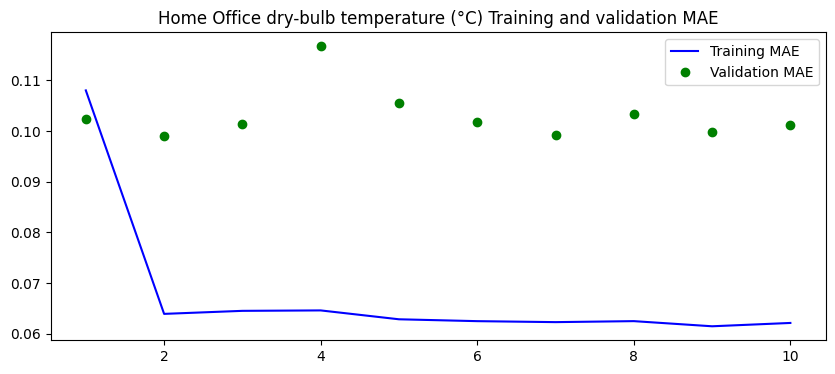

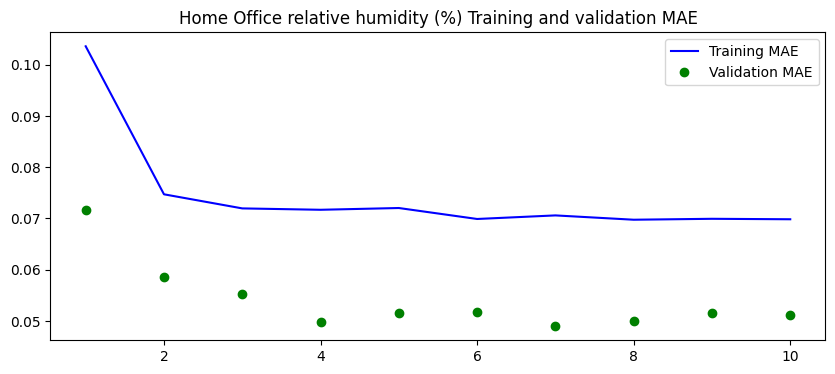

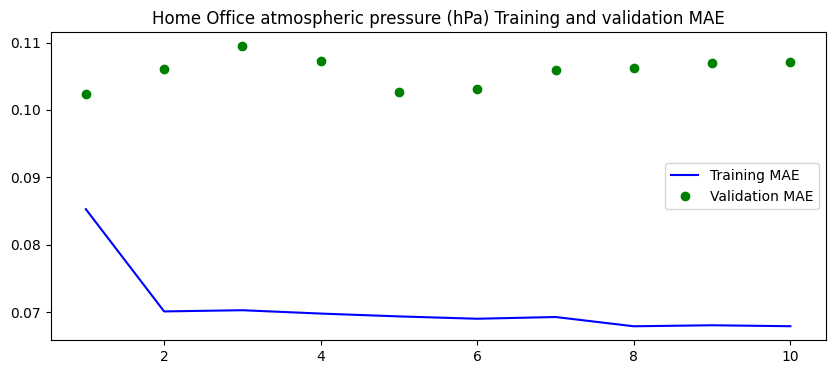

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step



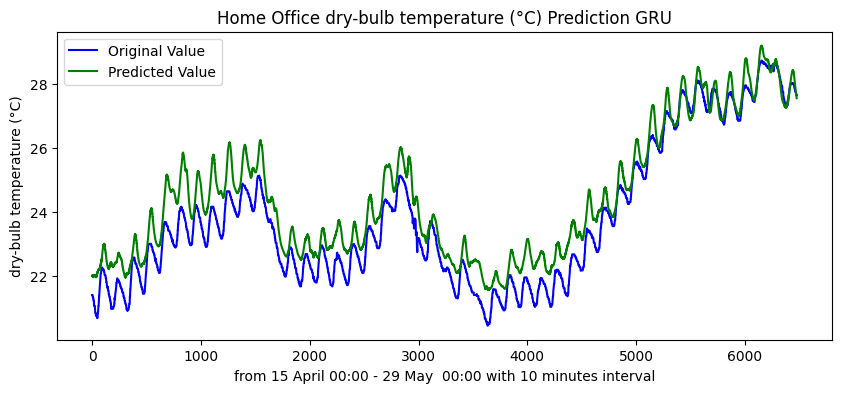

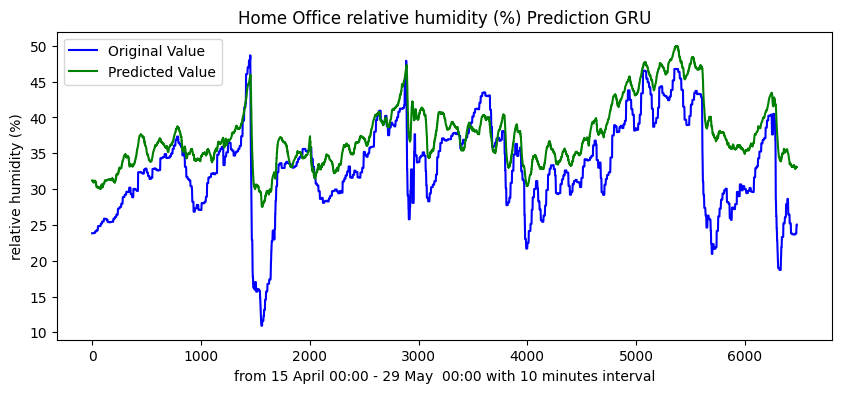

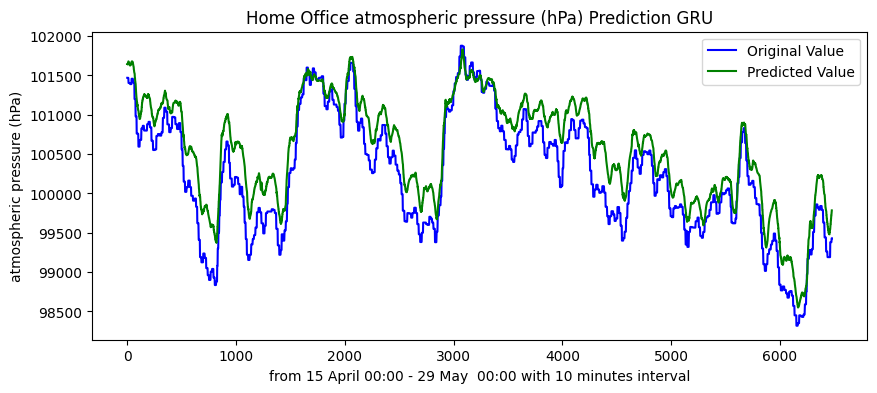


dry-bulb temperature (°C)
MAE: 0.684
MSE: 0.815
RMSE: 0.903

relative humidity (%)
MAE: 5.285
MSE: 59.422
RMSE: 7.709

atmospheric pressure (hPa)
MAE: 581.633
MSE: 484542.579
RMSE: 696.091


In [ ]:
finish(model_name='GRU',room_number=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, None, 20)       │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,411 (13.32 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, None, 20)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571 (13.95 KB)

 Trainable params: 3,571 (13.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, None, 20)       │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,651 (14.26 KB)

 Trainable params: 3,651 (14.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 180ms/step - loss: 0.2522 - mae: 0.1290 - val_loss: 0.0390 - val_mae: 0.1192 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0218 - mae: 0.0654 - val_loss: 0.0169 - val_mae: 0.0918 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0112 - mae: 0.0639 - val_loss: 0.0153 - val_mae: 0.0959 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 179ms/step - loss: 0.0092 - mae: 0.0636 - val_loss: 0.0165 - val_mae: 0.0997 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0104 - mae: 0.0682 - val_loss: 0.0159 - val_mae: 0.0983 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 179ms/step - loss: 0.0096 - mae: 0.0641 - val_loss: 0.0167 - val_mae: 0.1017 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0094 - mae: 0.0637 - val_loss: 0.0167 - val_mae: 0.1

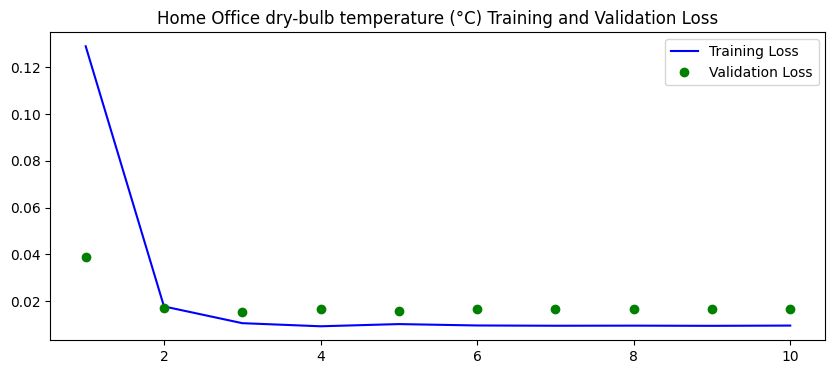

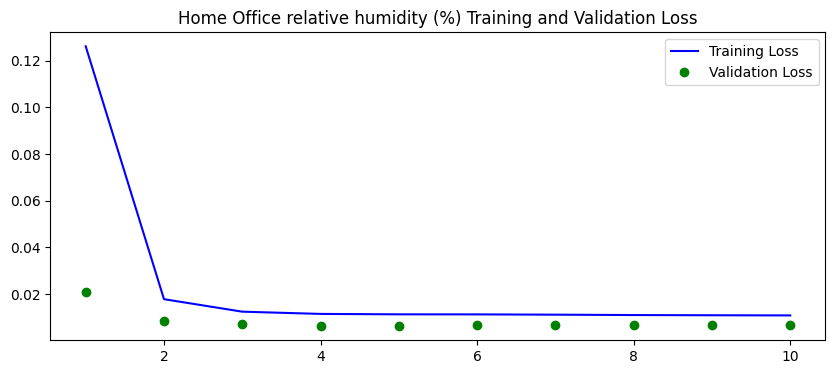

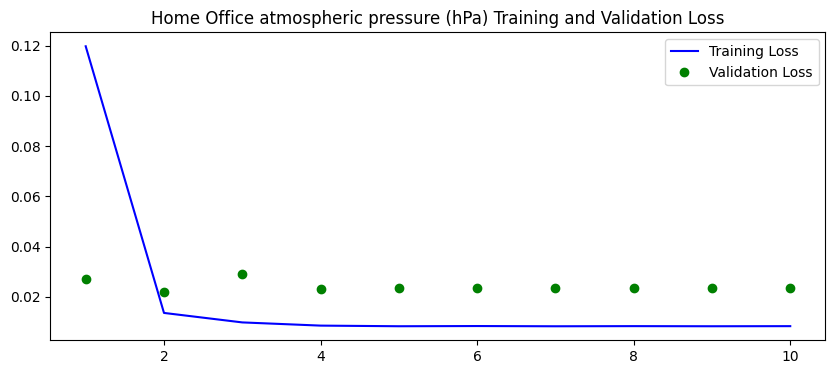

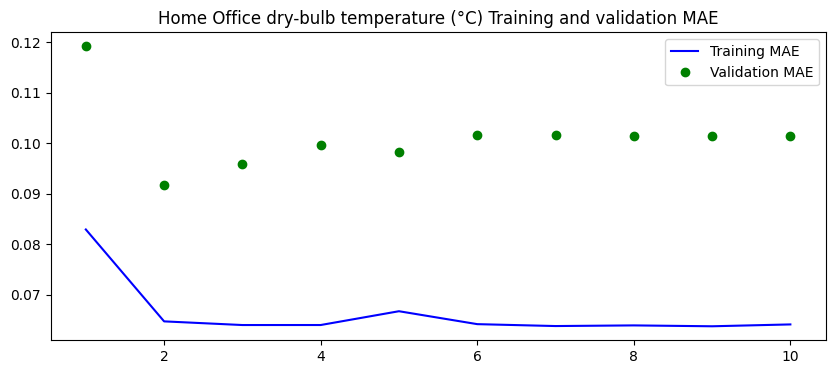

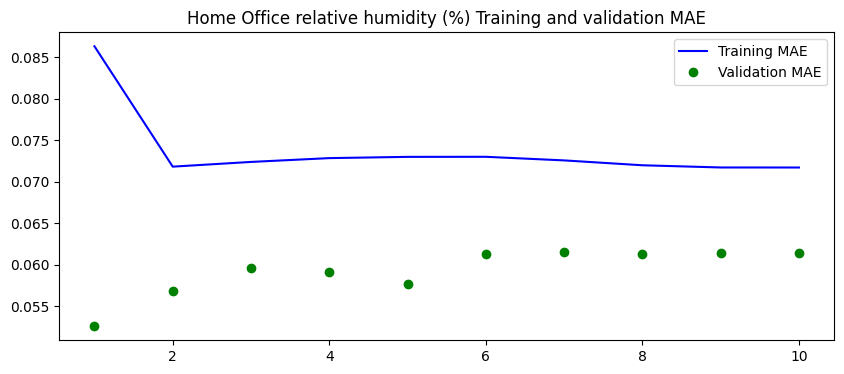

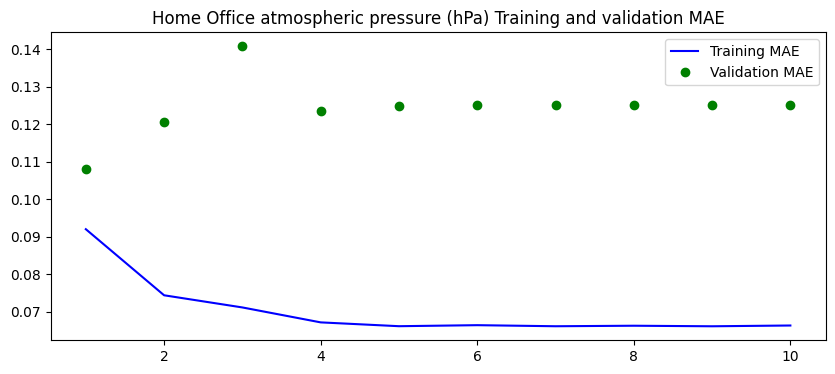

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step



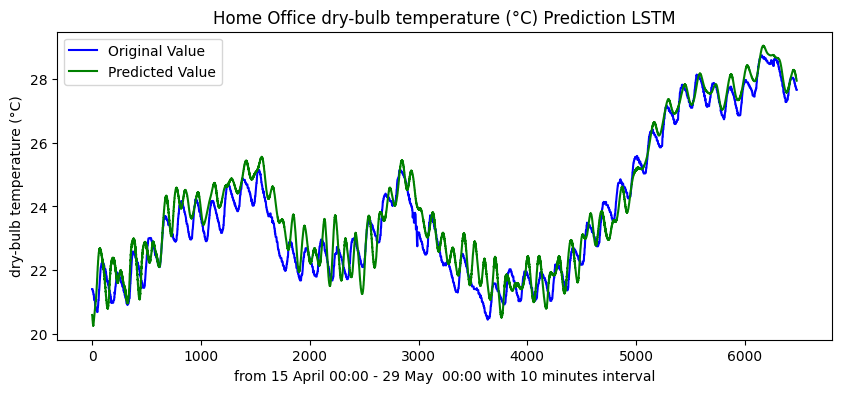

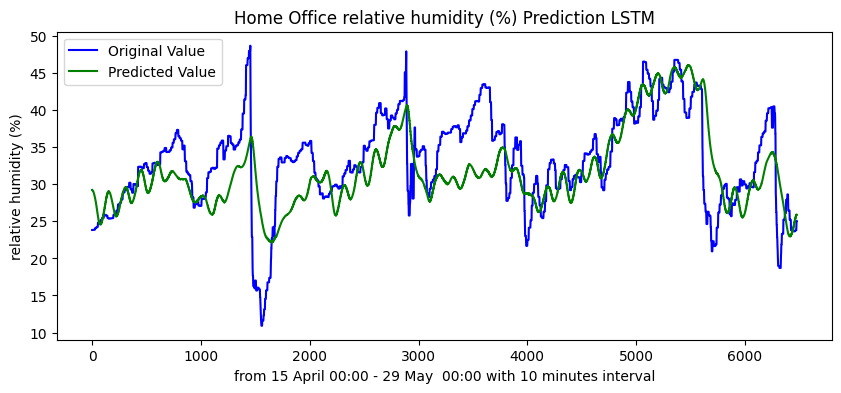

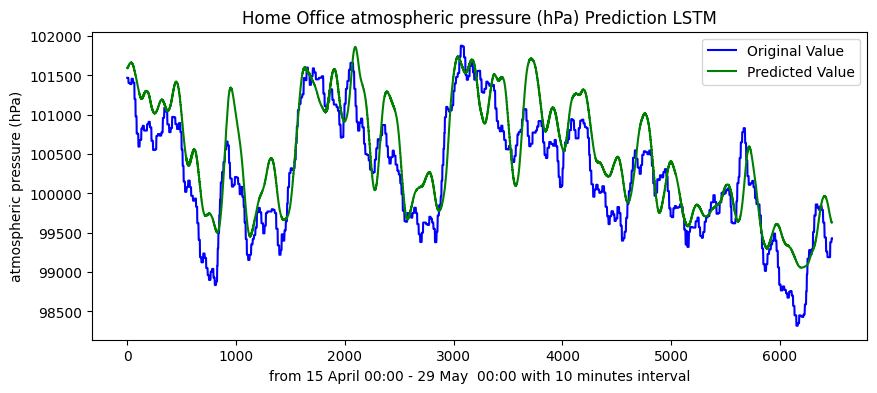


dry-bulb temperature (°C)
MAE: 0.685
MSE: 0.779
RMSE: 0.882

relative humidity (%)
MAE: 5.526
MSE: 50.749
RMSE: 7.124

atmospheric pressure (hPa)
MAE: 592.907
MSE: 565151.380
RMSE: 751.766


In [ ]:
finish(model_name='LSTM',room_number=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 316ms/step - loss: 0.4840 - mae: 0.0839 - val_loss: 0.0222 - val_mae: 0.1028 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 316ms/step - loss: 0.0136 - mae: 0.0685 - val_loss: 0.0196 - val_mae: 0.1112 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 315ms/step - loss: 0.0105 - mae: 0.0668 - val_loss: 0.0216 - val_mae: 0.1193 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 315ms/step - loss: 0.0093 - mae: 0.0628 - val_loss: 0.0190 - val_mae: 0.1104 - learning_rate: 1.0000e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0094 - mae: 0.0628 - val_loss: 0.0177 - val_mae: 0.1058 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 315ms/step - loss: 0.0097 - mae: 0.0638 - val_loss: 0.0202 - val_mae: 0.1149 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 316ms/step - loss: 0.0094 - mae: 0.0631 - val_loss: 0.0190 - v

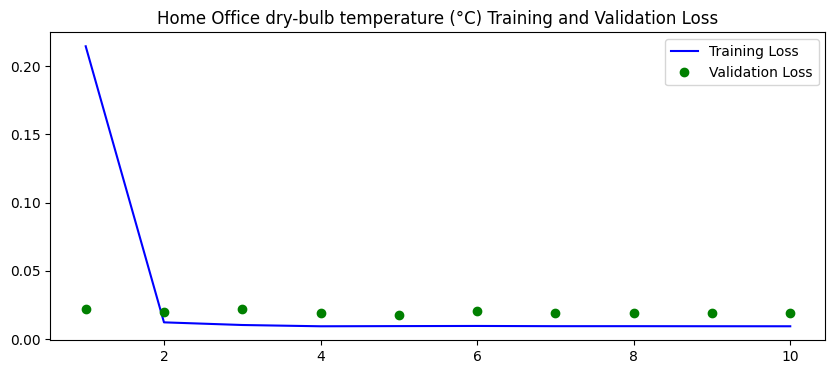

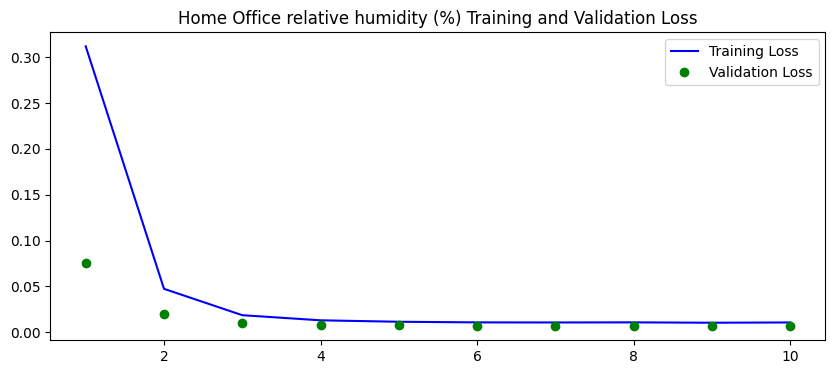

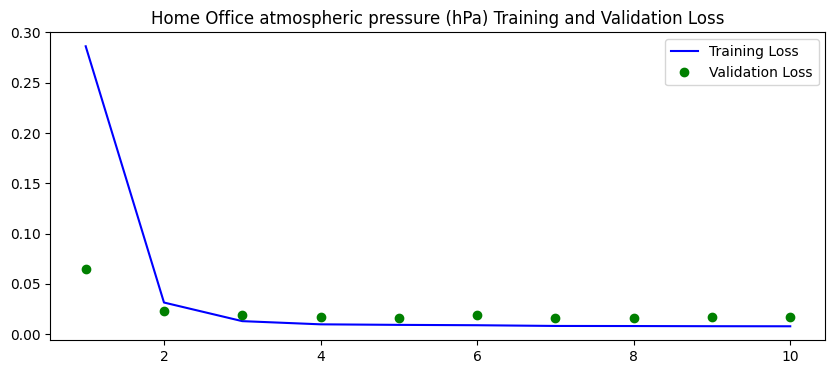

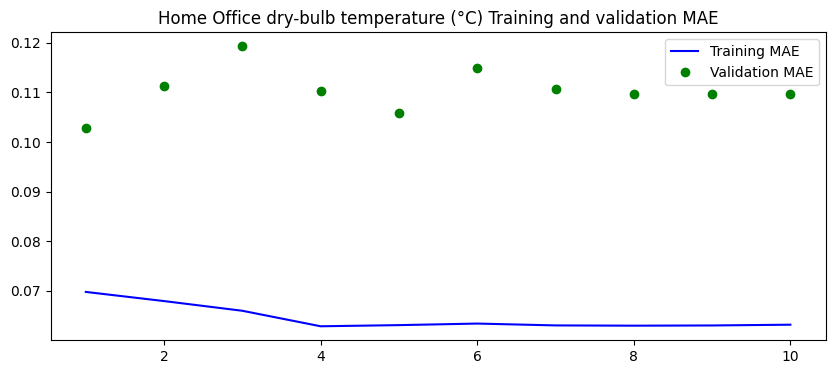

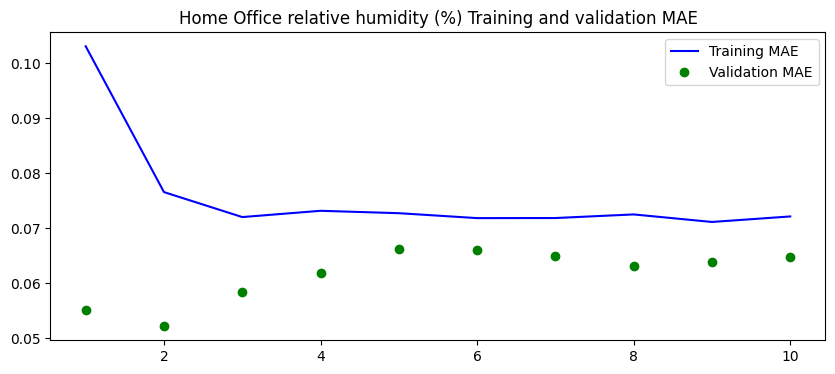

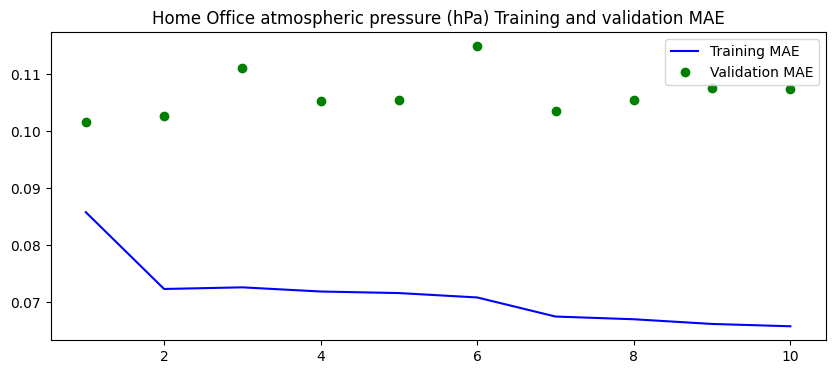

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step



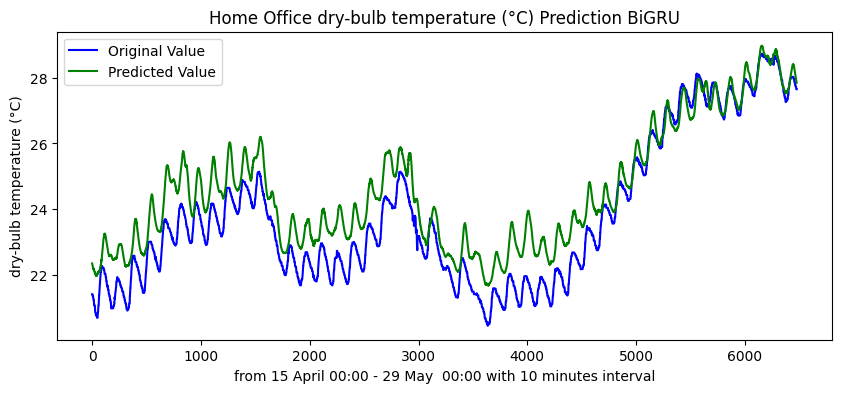

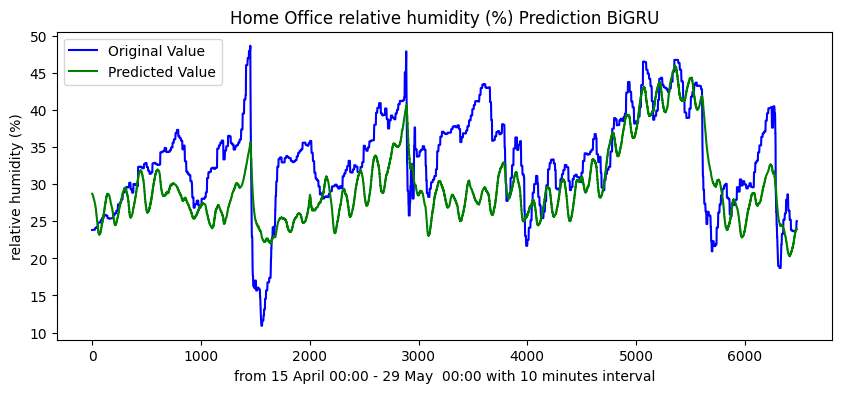

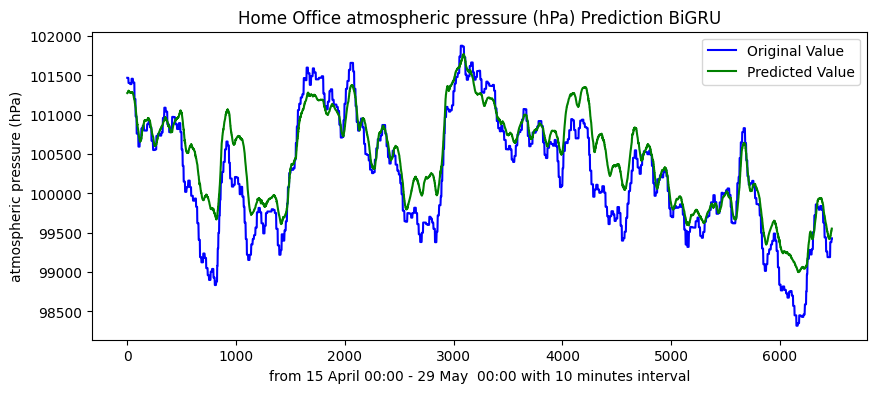


dry-bulb temperature (°C)
MAE: 0.831
MSE: 1.054
RMSE: 1.027

relative humidity (%)
MAE: 6.208
MSE: 59.014
RMSE: 7.682

atmospheric pressure (hPa)
MAE: 494.141
MSE: 392841.966
RMSE: 626.771


In [ ]:
finish(model_name='BiGRU',room_number=1)

## Room 3 Forecasting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_20 (GRU)                    │ (None, None, 25)       │         2,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ (None, 13)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049 (15.82 KB)

 Trainable params: 4,049 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_22 (GRU)                    │ (None, None, 20)       │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_23 (GRU)                    │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771 (10.82 KB)

 Trainable params: 2,771 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_24 (GRU)                    │ (None, None, 20)       │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831 (11.06 KB)

 Trainable params: 2,831 (11.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - loss: 0.2479 - mae: 0.1160 - val_loss: 0.0345 - val_mae: 0.0692 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0225 - mae: 0.0488 - val_loss: 0.0160 - val_mae: 0.0732 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0089 - mae: 0.0492 - val_loss: 0.0114 - val_mae: 0.0705 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0067 - mae: 0.0501 - val_loss: 0.0121 - val_mae: 0.0757 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0056 - mae: 0.0471 - val_loss: 0.0114 - val_mae: 0.0734 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0057 - mae: 0.0477 - val_loss: 0.0116 - val_mae: 0.0735 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 177ms/step - loss: 0.0056 - mae: 0.0474 - val_loss: 0.0114 - val_mae: 0.0

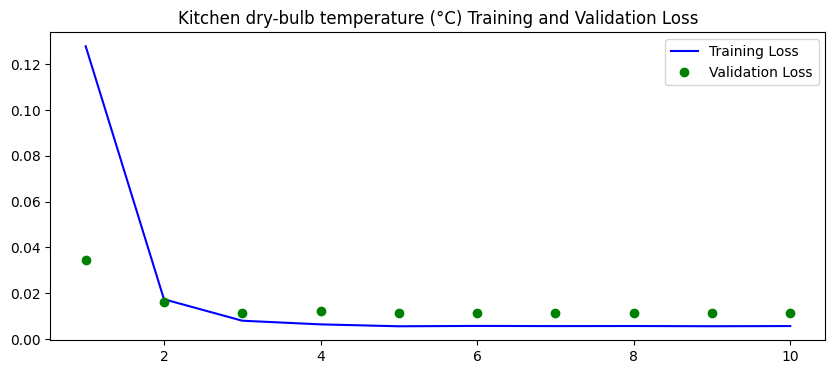

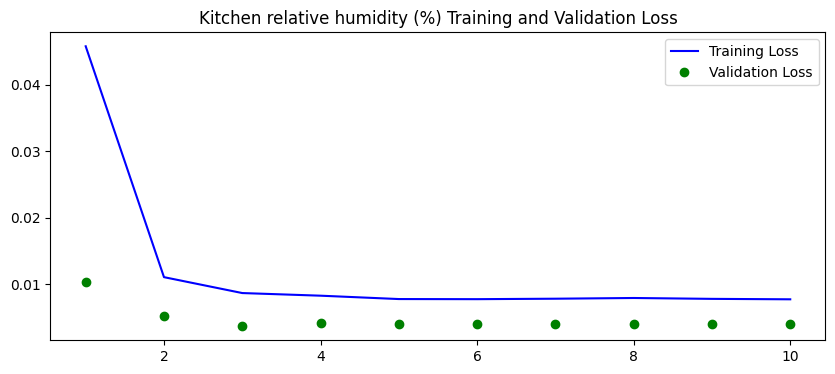

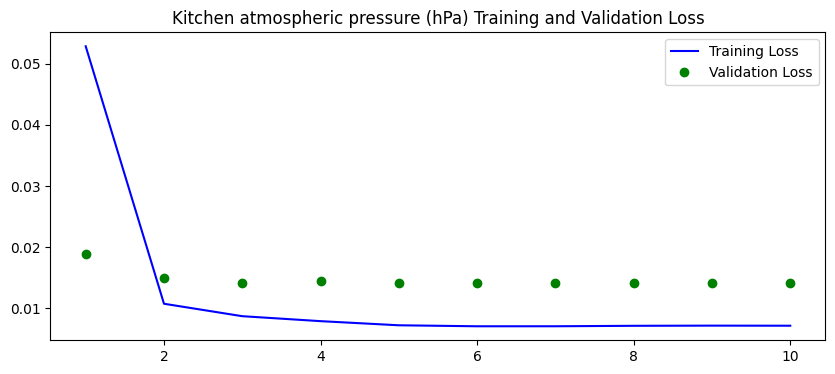

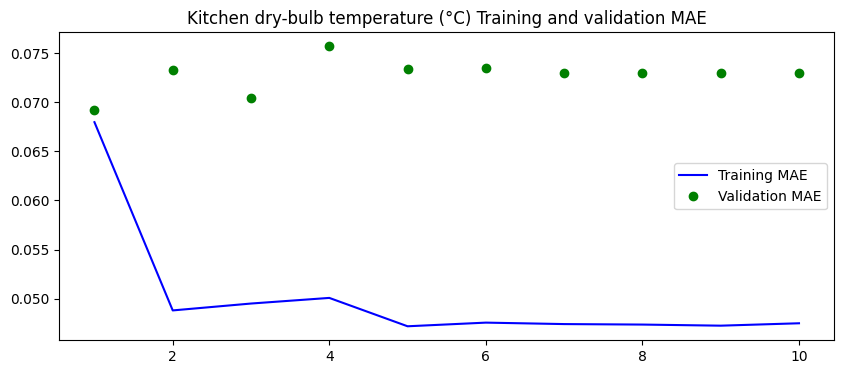

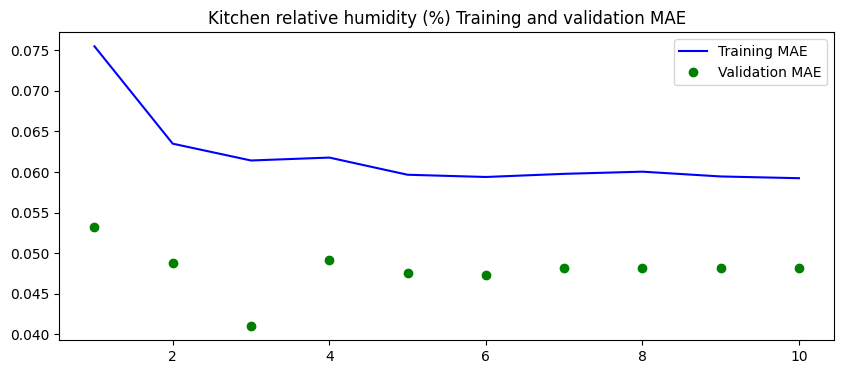

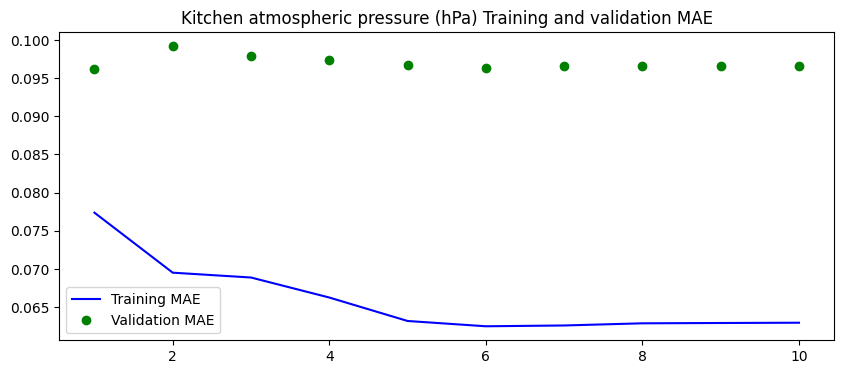

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step



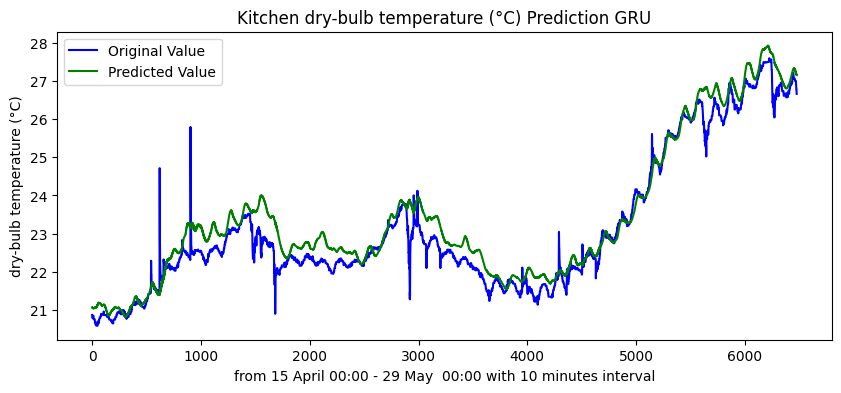

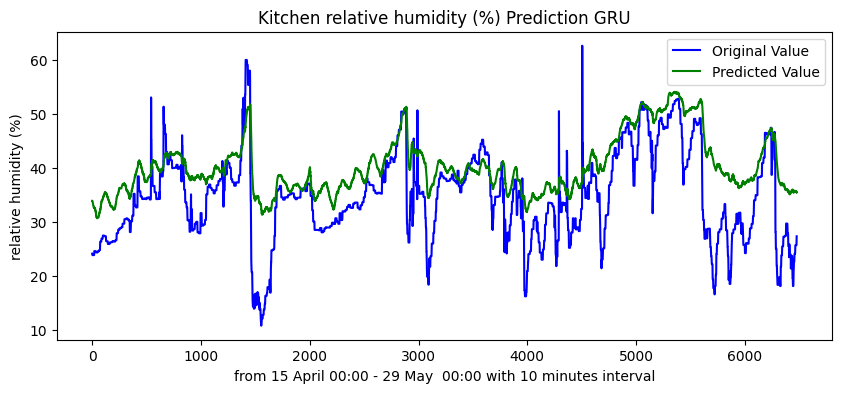

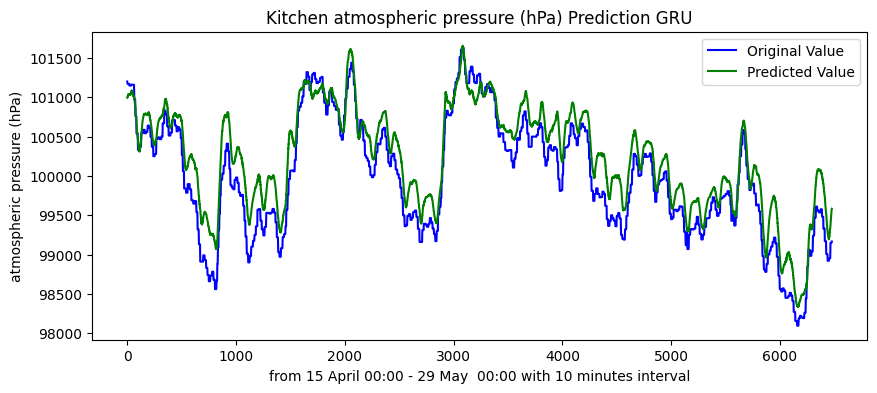


dry-bulb temperature (°C)
MAE: 0.496
MSE: 0.374
RMSE: 0.612

relative humidity (%)
MAE: 7.181
MSE: 100.869
RMSE: 10.043

atmospheric pressure (hPa)
MAE: 533.681
MSE: 426967.199
RMSE: 653.427


In [ ]:
finish(model_name='GRU',room_number=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, None, 20)       │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,411 (13.32 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, None, 20)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571 (13.95 KB)

 Trainable params: 3,571 (13.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, None, 20)       │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,651 (14.26 KB)

 Trainable params: 3,651 (14.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - loss: 0.2470 - mae: 0.1445 - val_loss: 0.0237 - val_mae: 0.0794 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0131 - mae: 0.0518 - val_loss: 0.0172 - val_mae: 0.0885 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 177ms/step - loss: 0.0075 - mae: 0.0520 - val_loss: 0.0138 - val_mae: 0.0819 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0063 - mae: 0.0508 - val_loss: 0.0125 - val_mae: 0.0825 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0063 - mae: 0.0517 - val_loss: 0.0172 - val_mae: 0.0939 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0056 - mae: 0.0490 - val_loss: 0.0131 - val_mae: 0.0836 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0053 - mae: 0.0483 - val_loss: 0.0130 - val_mae: 0.0830 

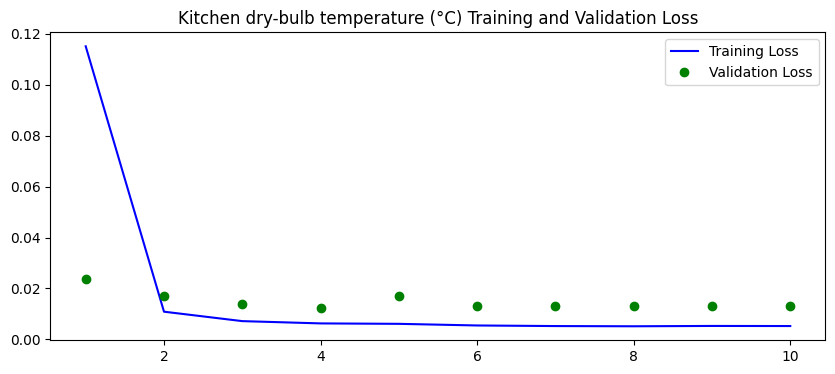

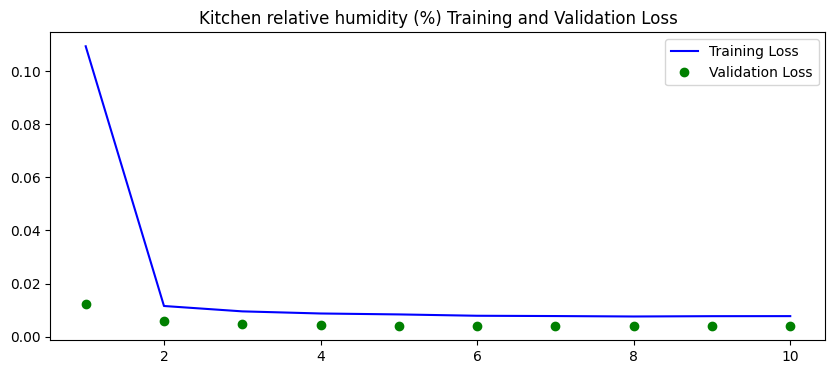

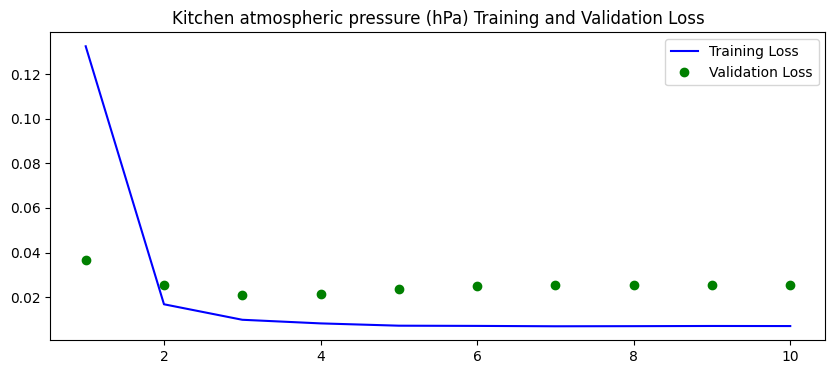

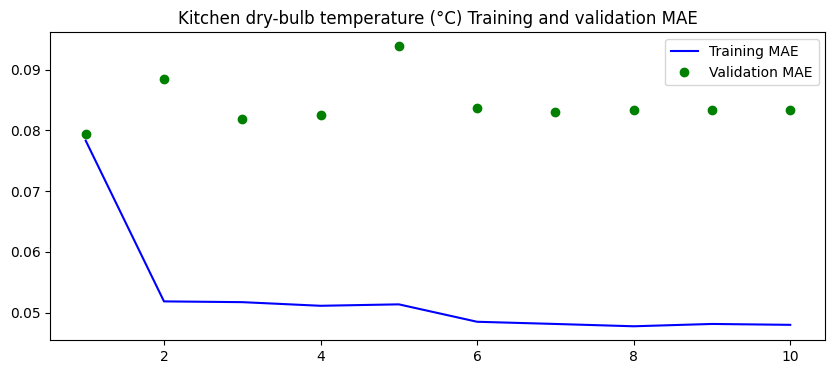

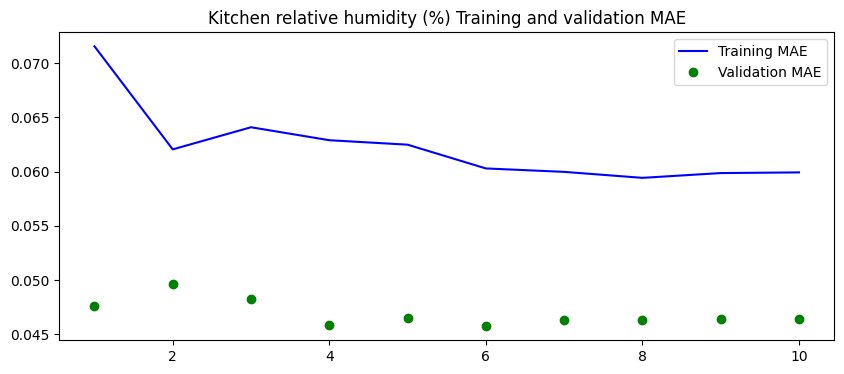

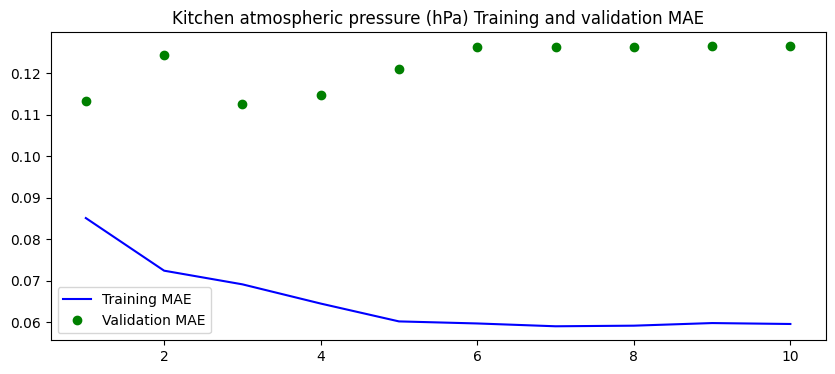

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step



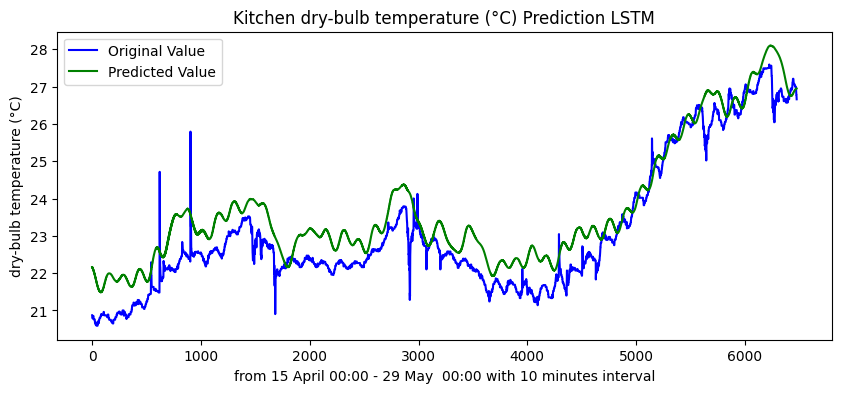

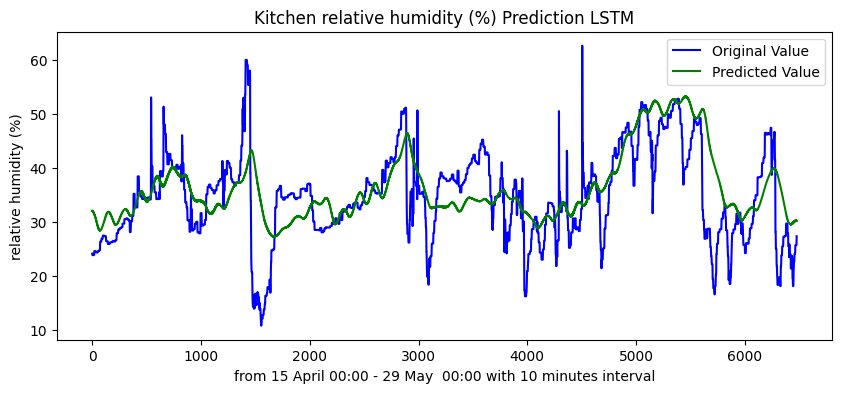

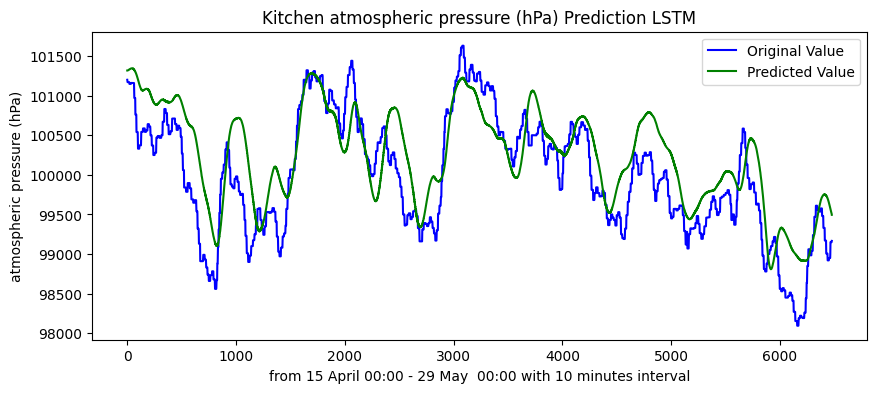


dry-bulb temperature (°C)
MAE: 0.651
MSE: 0.602
RMSE: 0.776

relative humidity (%)
MAE: 6.885
MSE: 84.694
RMSE: 9.203

atmospheric pressure (hPa)
MAE: 583.595
MSE: 542100.528
RMSE: 736.275


In [ ]:
finish(model_name='LSTM',room_number=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_16                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 318ms/step - loss: 0.5203 - mae: 0.0974 - val_loss: 0.0262 - val_mae: 0.0720 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0143 - mae: 0.0499 - val_loss: 0.0124 - val_mae: 0.0740 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0065 - mae: 0.0511 - val_loss: 0.0115 - val_mae: 0.0751 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0061 - mae: 0.0512 - val_loss: 0.0106 - val_mae: 0.0739 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0060 - mae: 0.0512 - val_loss: 0.0109 - val_mae: 0.0727 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0056 - mae: 0.0490 - val_loss: 0.0116 - val_mae: 0.0764 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0056 - mae: 0.0485 - val_loss: 0.0115 - val_mae: 

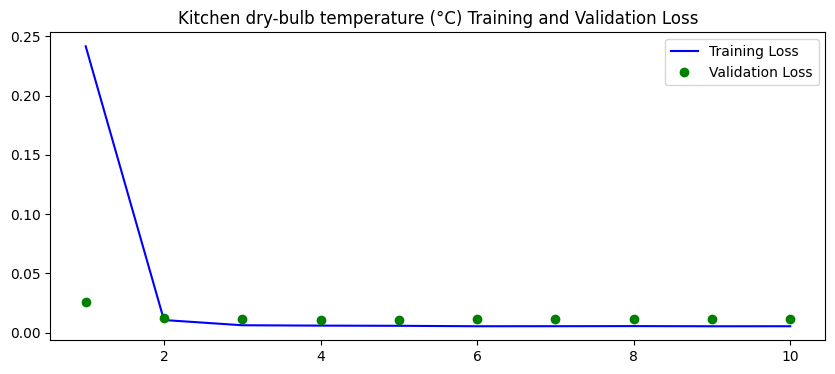

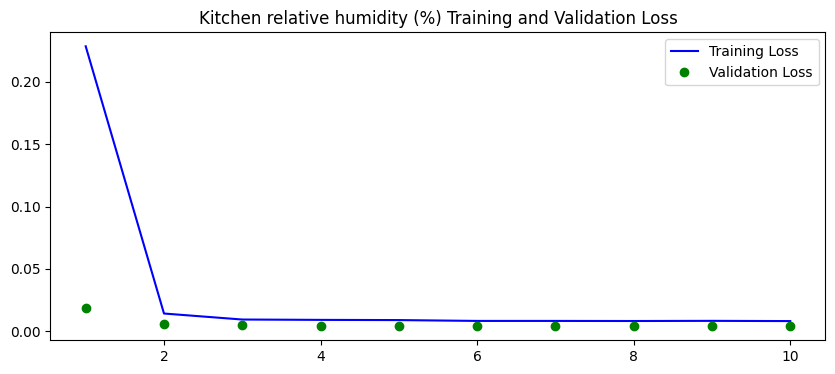

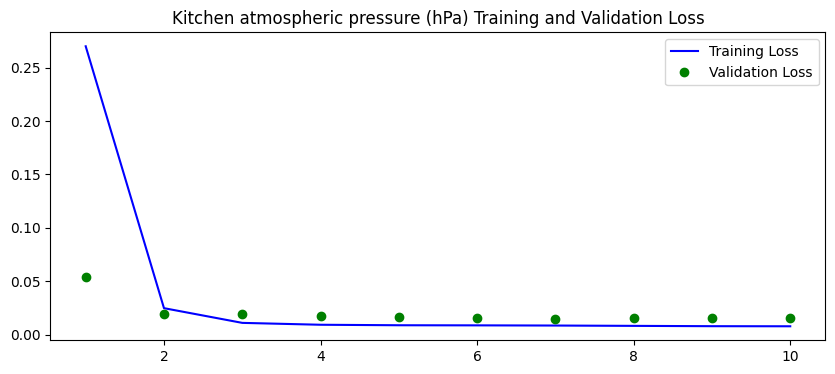

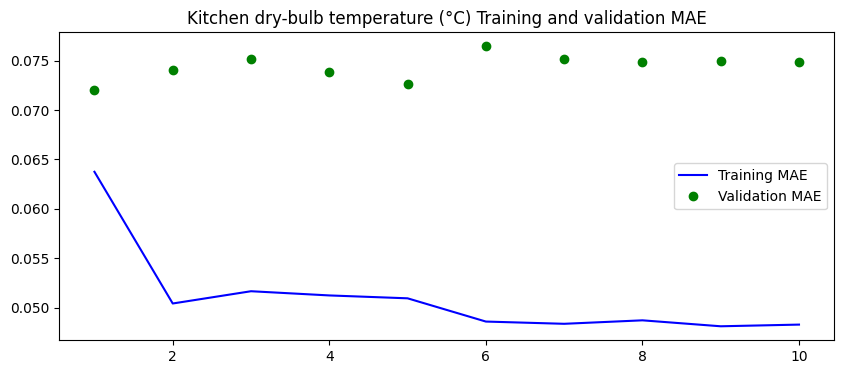

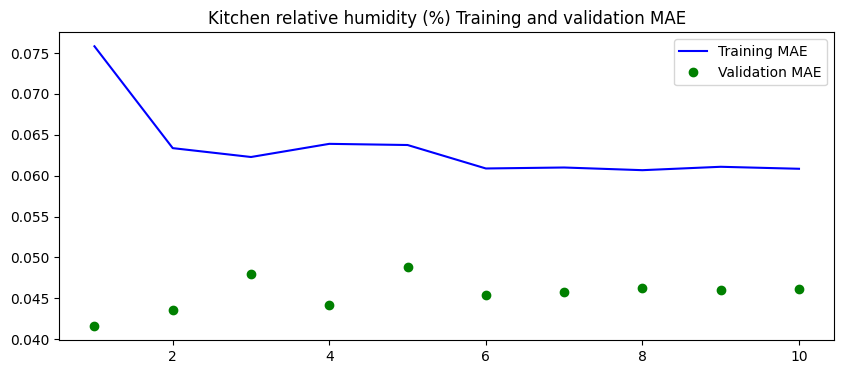

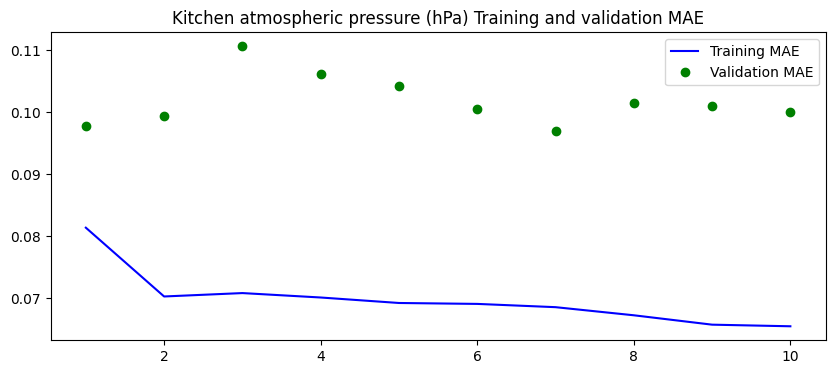

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step



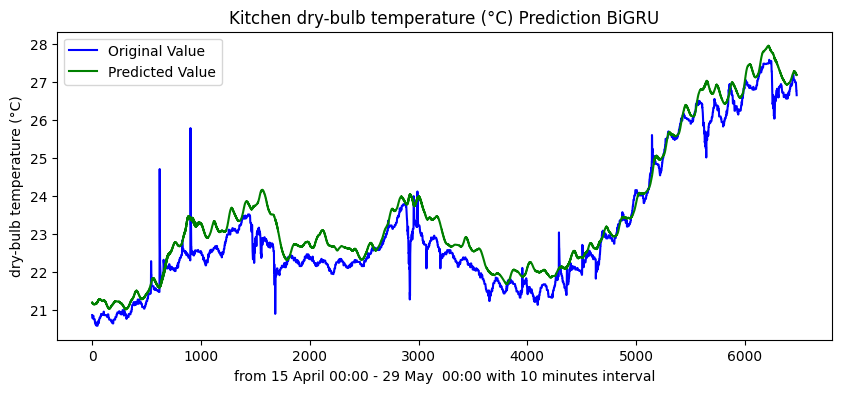

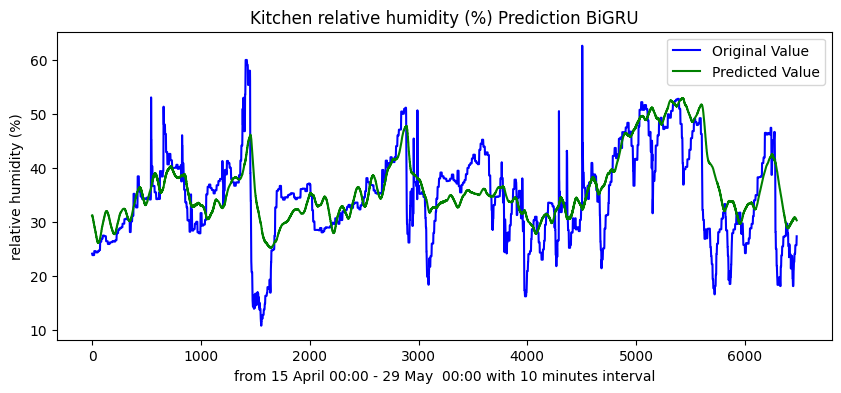

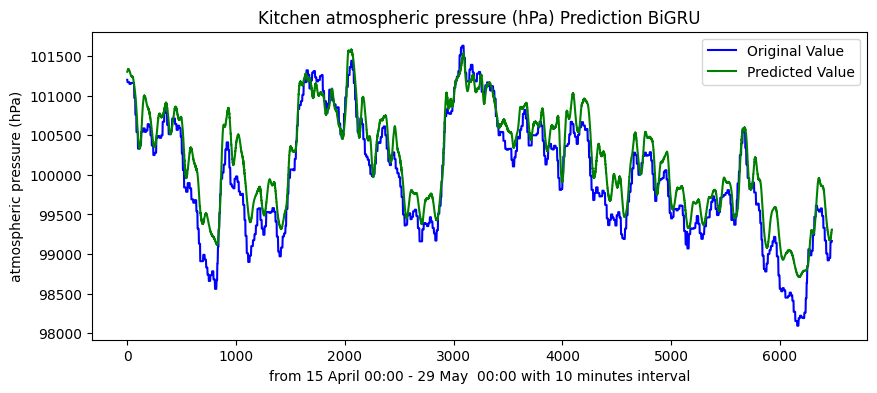


dry-bulb temperature (°C)
MAE: 0.514
MSE: 0.414
RMSE: 0.643

relative humidity (%)
MAE: 6.778
MSE: 82.832
RMSE: 9.101

atmospheric pressure (hPa)
MAE: 527.485
MSE: 426358.452
RMSE: 652.961


In [ ]:
finish(model_name='BiGRU',room_number=2)

## Room 4 Forecasting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_32 (GRU)                    │ (None, None, 25)       │         2,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_33 (GRU)                    │ (None, 13)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049 (15.82 KB)

 Trainable params: 4,049 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_34 (GRU)                    │ (None, None, 20)       │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_35 (GRU)                    │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771 (10.82 KB)

 Trainable params: 2,771 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_36 (GRU)                    │ (None, None, 20)       │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831 (11.06 KB)

 Trainable params: 2,831 (11.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 177ms/step - loss: 0.3375 - mae: 0.1826 - val_loss: 0.0446 - val_mae: 0.0548 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0323 - mae: 0.0383 - val_loss: 0.0163 - val_mae: 0.0527 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0117 - mae: 0.0384 - val_loss: 0.0102 - val_mae: 0.0636 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0058 - mae: 0.0391 - val_loss: 0.0070 - val_mae: 0.0574 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0039 - mae: 0.0389 - val_loss: 0.0054 - val_mae: 0.0509 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0055 - val_mae: 0.0542 - learning_rate: 0.0010
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0027 - mae: 0.0359 - val_loss: 0.0052 - val_mae: 0.0520 - le

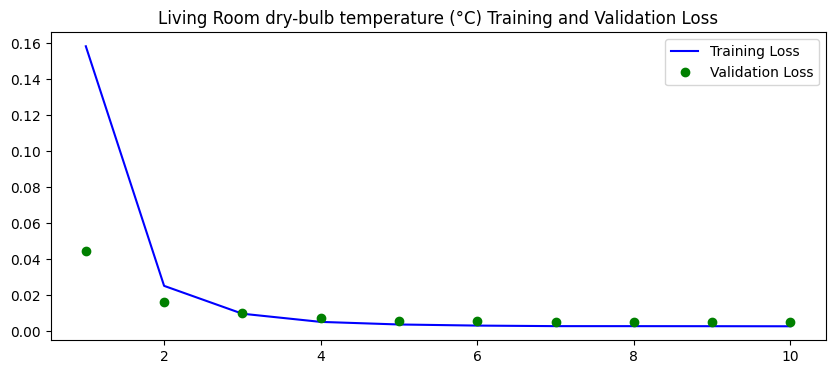

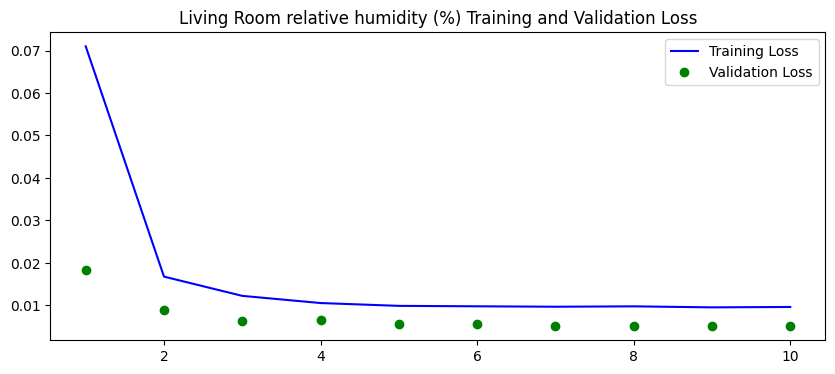

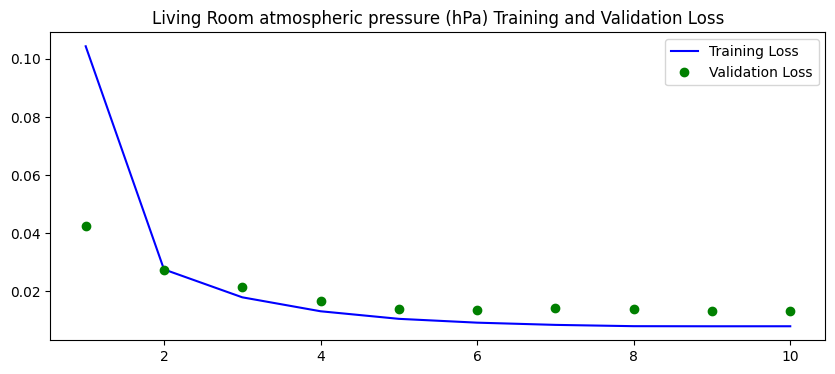

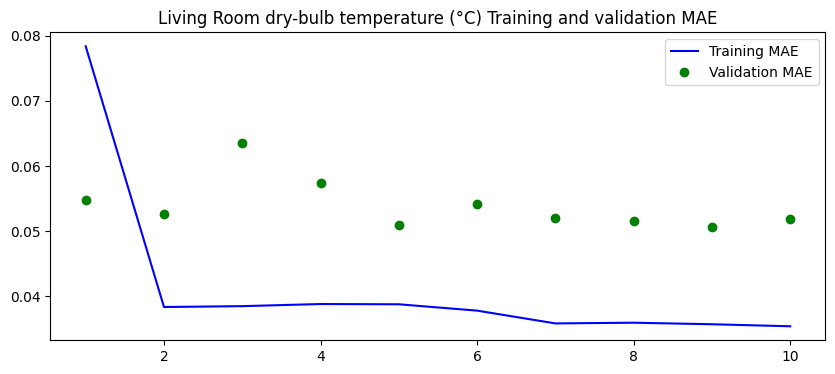

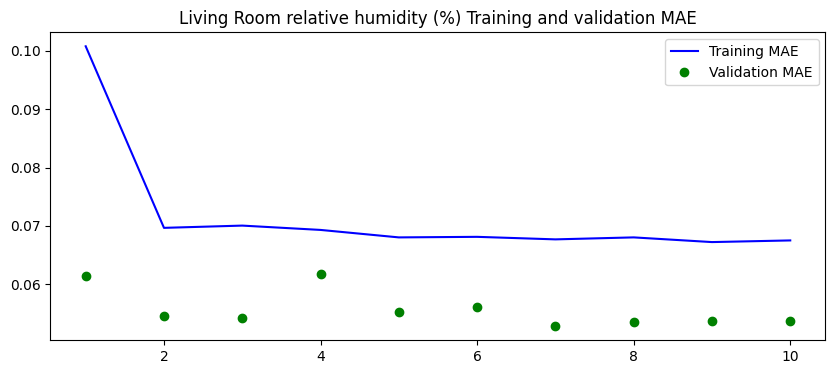

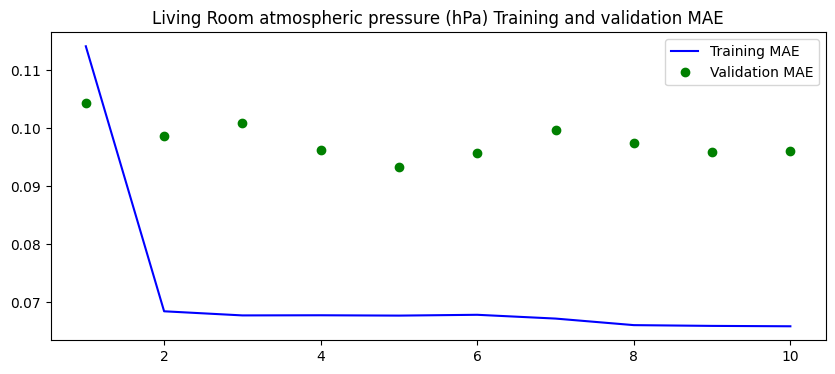

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step



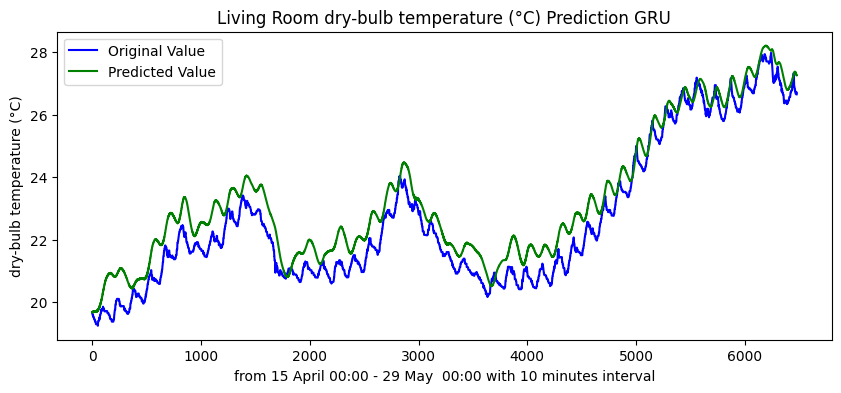

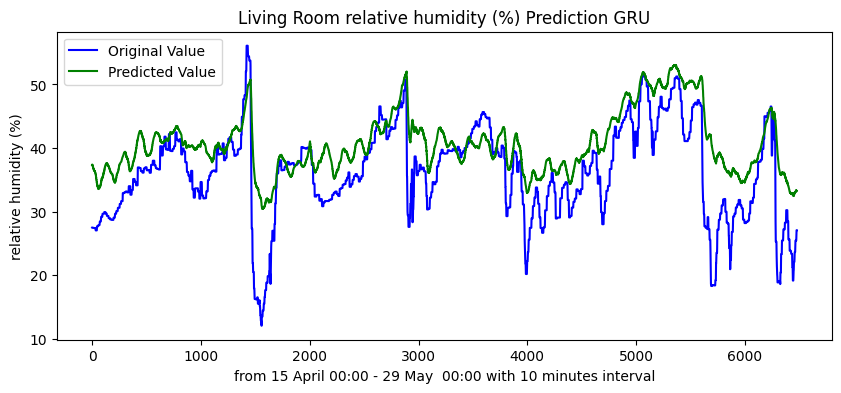

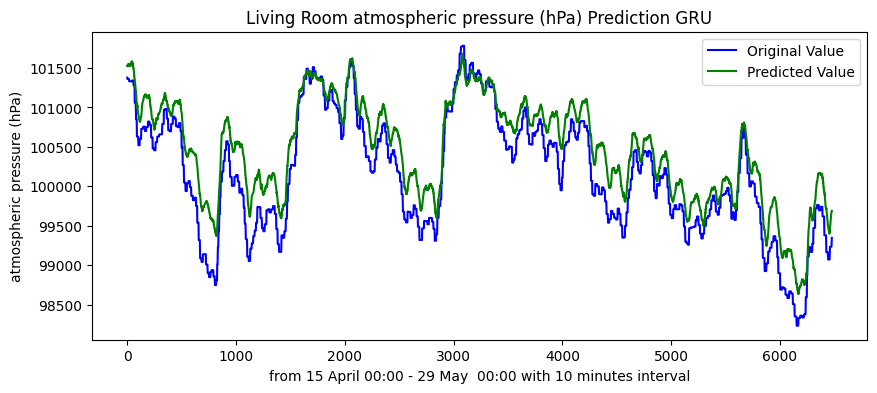


dry-bulb temperature (°C)
MAE: 0.639
MSE: 0.657
RMSE: 0.811

relative humidity (%)
MAE: 6.230
MSE: 79.230
RMSE: 8.901

atmospheric pressure (hPa)
MAE: 563.837
MSE: 458581.466
RMSE: 677.186


In [ ]:
finish(model_name='GRU',room_number=3)

In [ ]:
finish(model_name='LSTM',room_number=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 20)       │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,411 (13.32 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, None, 20)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571 (13.95 KB)

 Trainable params: 3,571 (13.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, None, 20)       │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,651 (14.26 KB)

 Trainable params: 3,651 (14.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 180ms/step - loss: 0.2442 - mae: 0.1139 - val_loss: 0.0218 - val_mae: 0.0627 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - loss: 0.0130 - mae: 0.0401 - val_loss: 0.0085 - val_mae: 0.0568 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - loss: 0.0050 - mae: 0.0411 - val_loss: 0.0082 - val_mae: 0.0620 - learning_rate: 0.0010
Epoch 4/10
122/500 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0037 - mae: 0.0397

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_18                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_20                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_22                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 317ms/step - loss: 0.5186 - mae: 0.0818 - val_loss: 0.0196 - val_mae: 0.0546 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0115 - mae: 0.0404 - val_loss: 0.0076 - val_mae: 0.0602 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0043 - mae: 0.0400 - val_loss: 0.0051 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0035 - mae: 0.0402 - val_loss: 0.0060 - val_mae: 0.0559 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0030 - mae: 0.0371 - val_loss: 0.0058 - val_mae: 0.0552 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0030 - mae: 0.0372 - val_loss: 0.0055 - val_mae: 0.0532 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0030 - mae: 0.0369 - val_loss: 0.0056 - val_m

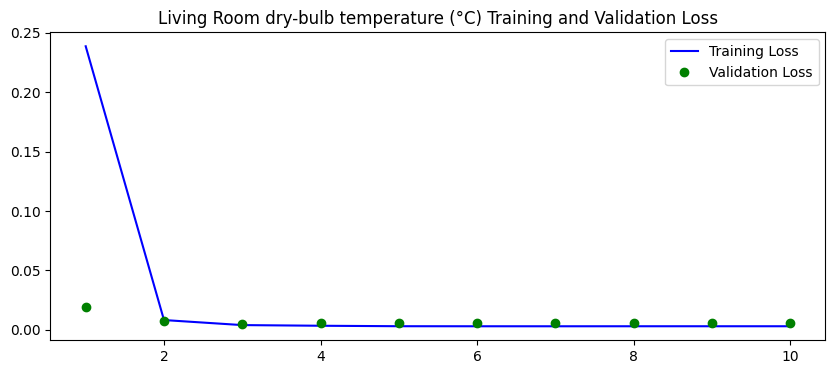

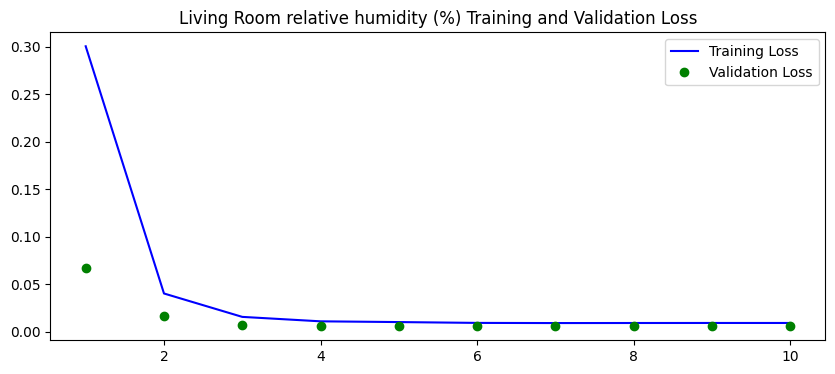

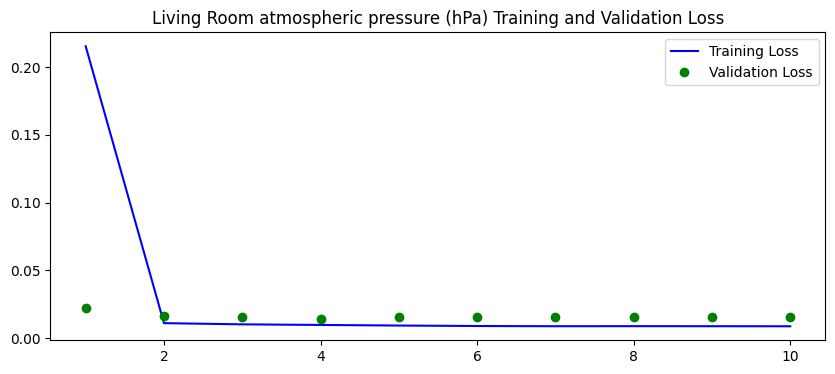

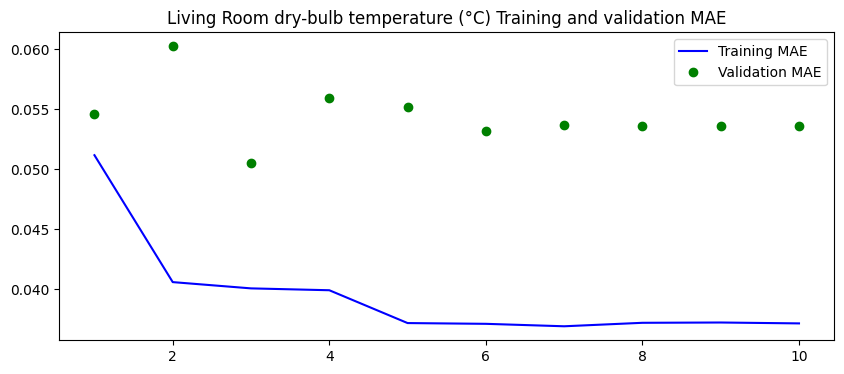

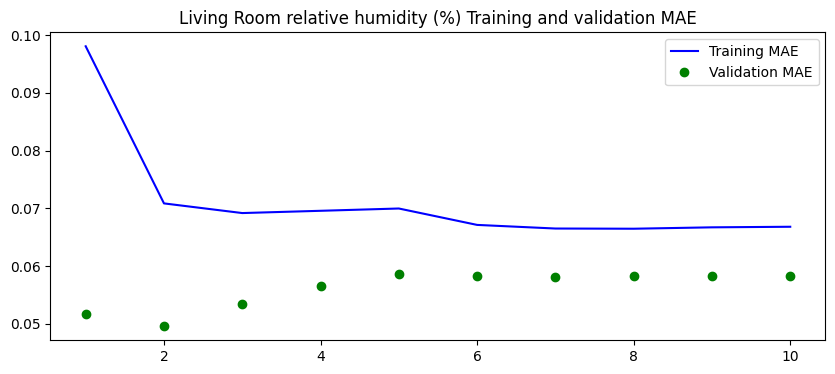

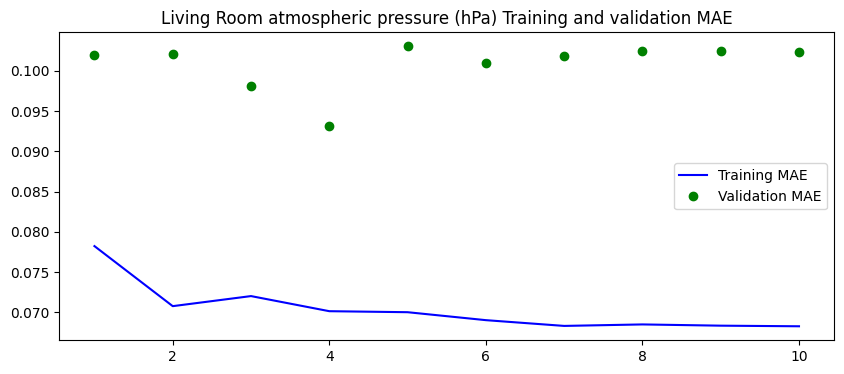

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step



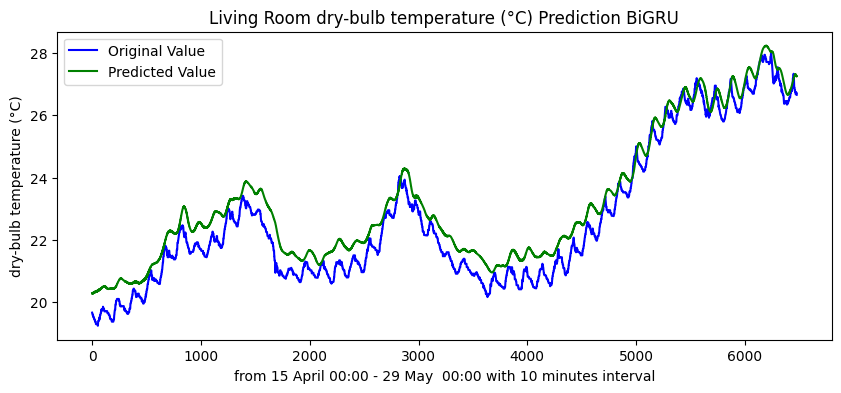

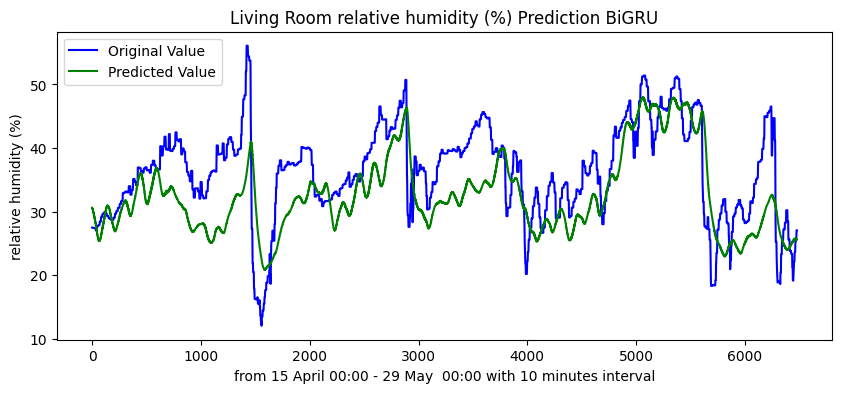

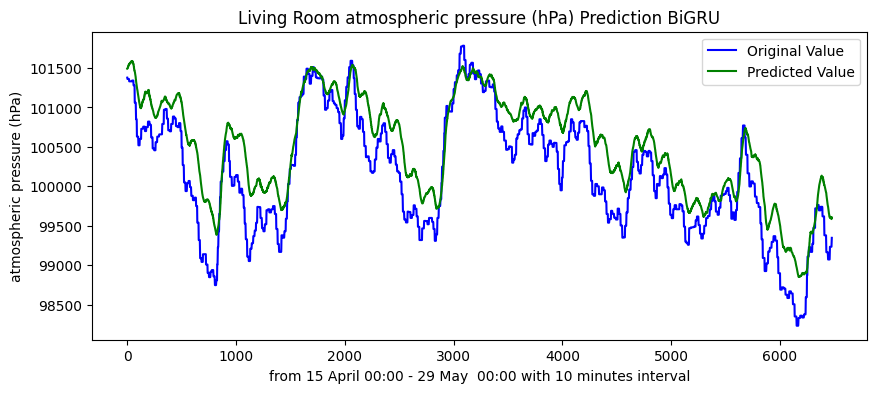


dry-bulb temperature (°C)
MAE: 0.605
MSE: 0.583
RMSE: 0.763

relative humidity (%)
MAE: 7.213
MSE: 79.943
RMSE: 8.941

atmospheric pressure (hPa)
MAE: 614.122
MSE: 547845.229
RMSE: 740.166


In [ ]:
finish(model_name='BiGRU',room_number=3)

## Room 5 Forecasting

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_44 (GRU)                    │ (None, None, 25)       │         2,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ (None, 13)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049 (15.82 KB)

 Trainable params: 4,049 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_46 (GRU)                    │ (None, None, 20)       │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_47 (GRU)                    │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771 (10.82 KB)

 Trainable params: 2,771 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_48 (GRU)                    │ (None, None, 20)       │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,831 (11.06 KB)

 Trainable params: 2,831 (11.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - loss: 0.2216 - mae: 0.0906 - val_loss: 0.0255 - val_mae: 0.0945 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0149 - mae: 0.0580 - val_loss: 0.0198 - val_mae: 0.1117 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 179ms/step - loss: 0.0085 - mae: 0.0582 - val_loss: 0.0124 - val_mae: 0.0851 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0075 - mae: 0.0574 - val_loss: 0.0124 - val_mae: 0.0863 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0069 - mae: 0.0545 - val_loss: 0.0126 - val_mae: 0.0875 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0068 - mae: 0.0546 - val_loss: 0.0135 - val_mae: 0.0909 - learning_rate: 1.0000e-05
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 179ms/step - loss: 0.0068 - mae: 0.0543 - val_loss: 0.0133 - val_mae: 0.0

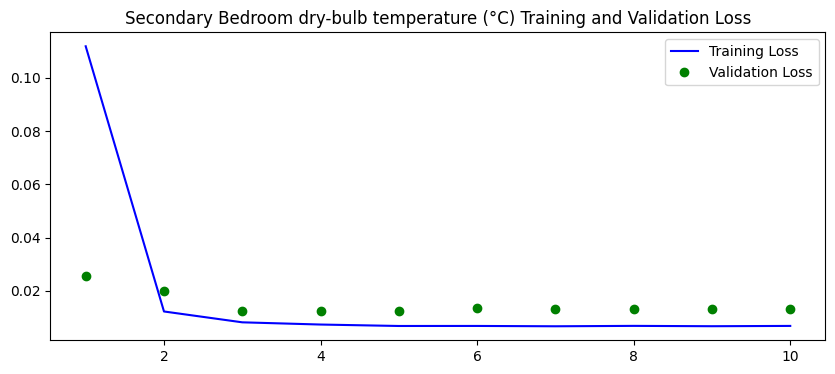

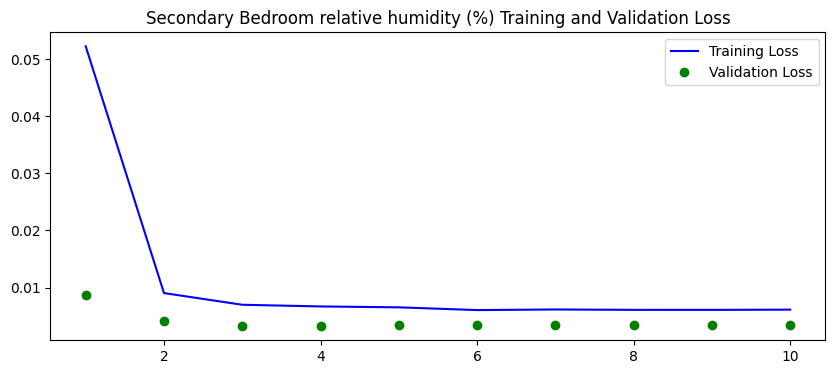

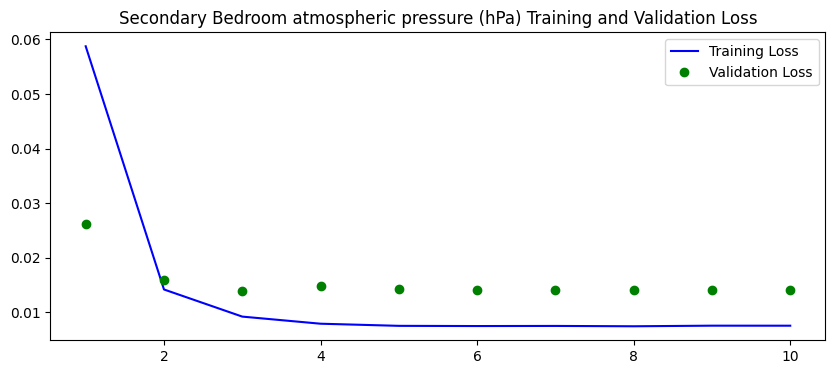

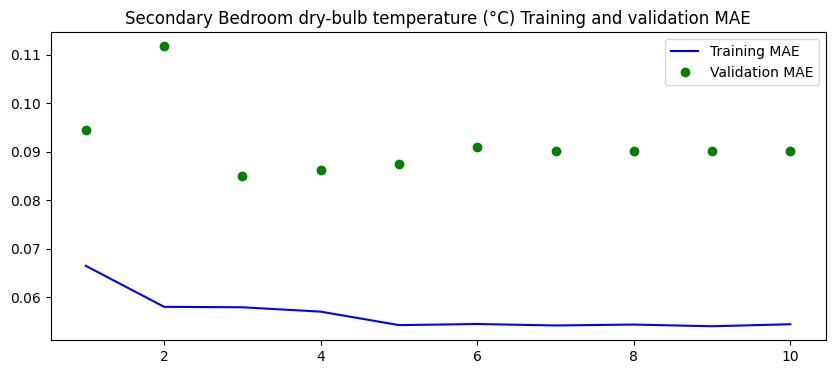

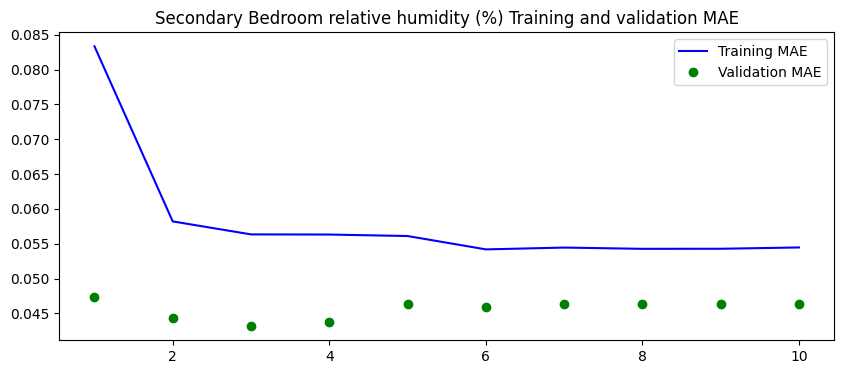

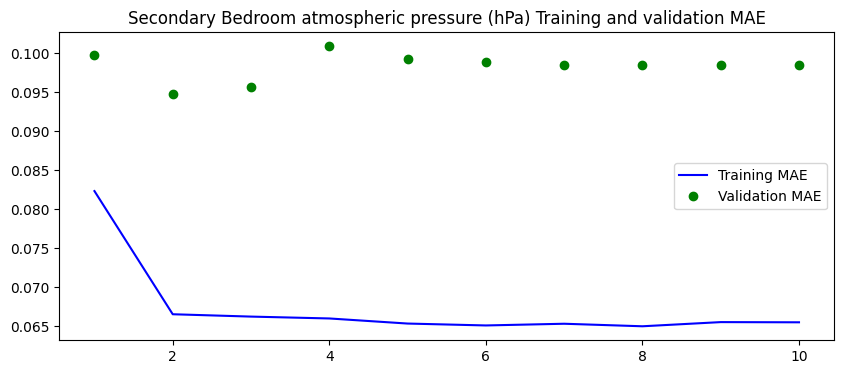

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step



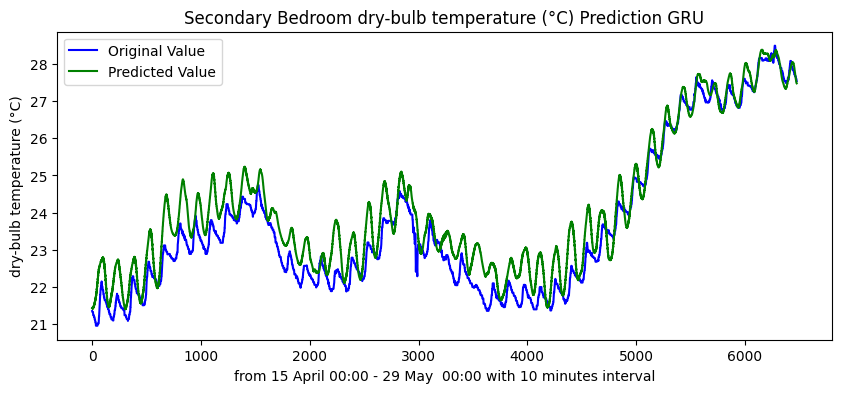

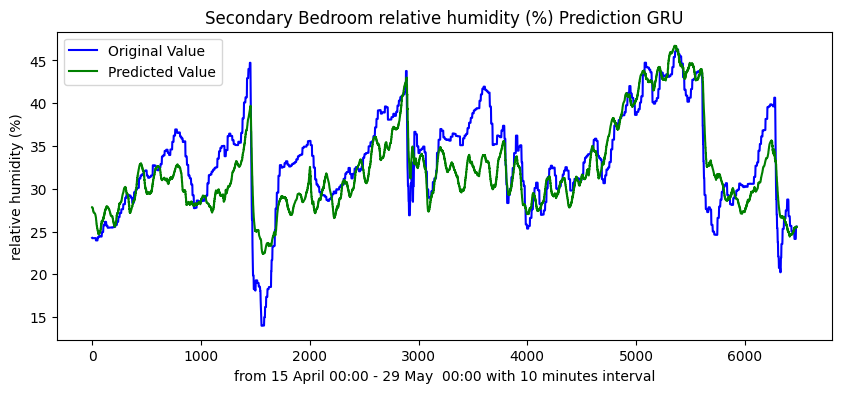

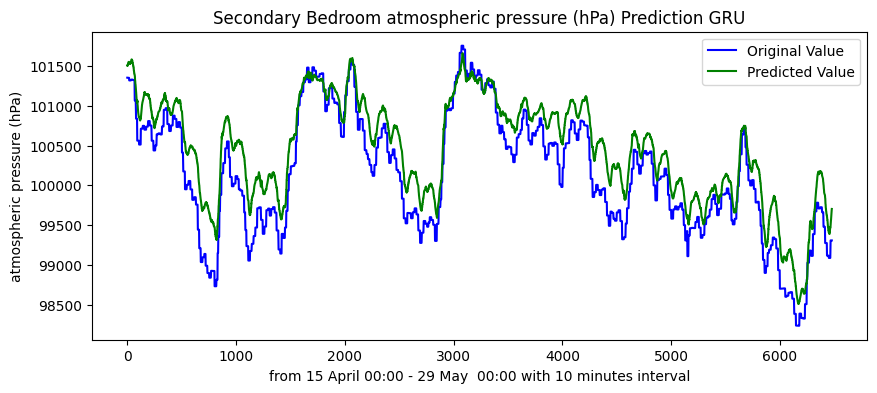


dry-bulb temperature (°C)
MAE: 0.580
MSE: 0.508
RMSE: 0.712

relative humidity (%)
MAE: 4.337
MSE: 34.404
RMSE: 5.865

atmospheric pressure (hPa)
MAE: 570.670
MSE: 471866.351
RMSE: 686.925


In [ ]:
finish(model_name='GRU',room_number=4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, None, 20)       │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,411 (13.32 KB)

 Trainable params: 3,411 (13.32 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, None, 20)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571 (13.95 KB)

 Trainable params: 3,571 (13.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, None, 20)       │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,651 (14.26 KB)

 Trainable params: 3,651 (14.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - loss: 0.2492 - mae: 0.1291 - val_loss: 0.0309 - val_mae: 0.0956 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - loss: 0.0188 - mae: 0.0588 - val_loss: 0.0178 - val_mae: 0.0935 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0099 - mae: 0.0584 - val_loss: 0.0155 - val_mae: 0.0918 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 179ms/step - loss: 0.0085 - mae: 0.0591 - val_loss: 0.0137 - val_mae: 0.0883 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0078 - mae: 0.0581 - val_loss: 0.0099 - val_mae: 0.0721 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0073 - mae: 0.0563 - val_loss: 0.0139 - val_mae: 0.0876 - learning_rate: 0.0010
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - loss: 0.0066 - mae: 0.0534 - val_loss: 0.0116 - val_mae: 0.0795 - le

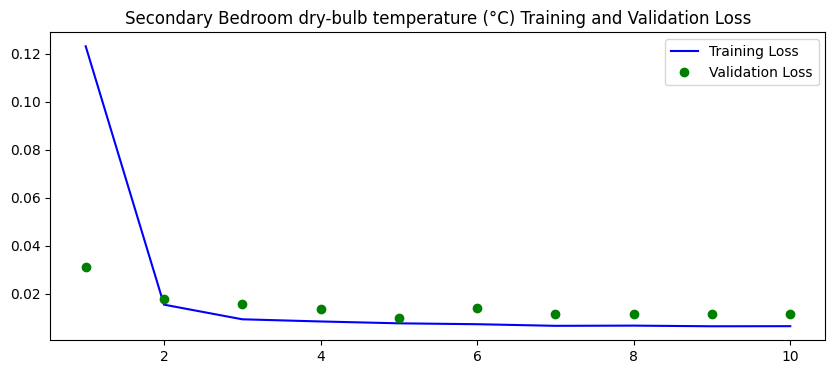

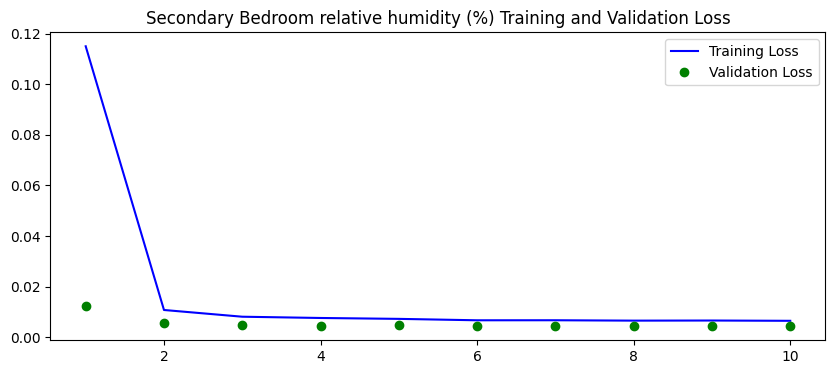

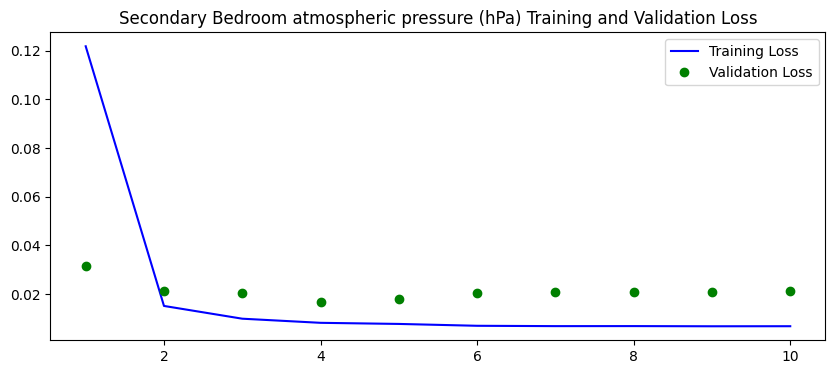

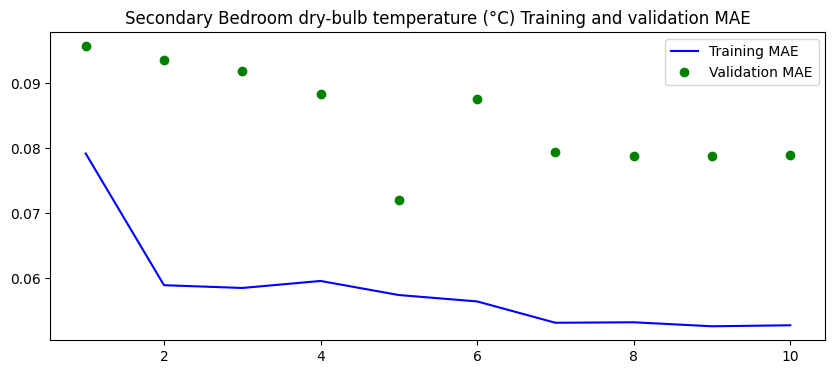

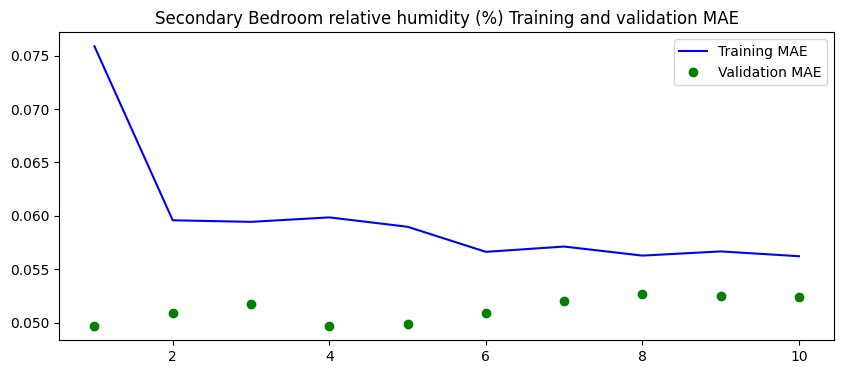

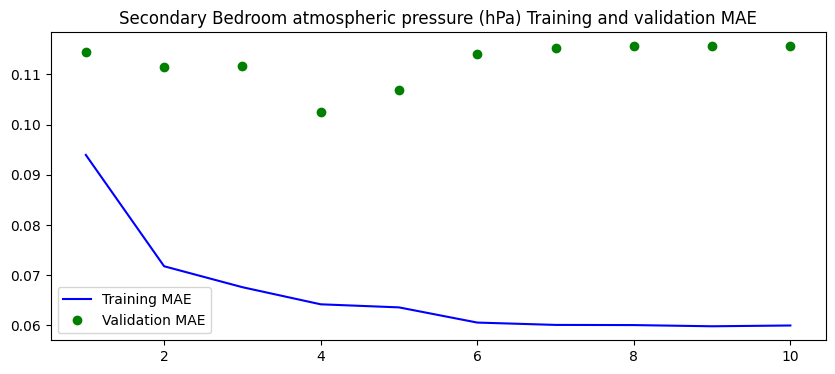

207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step



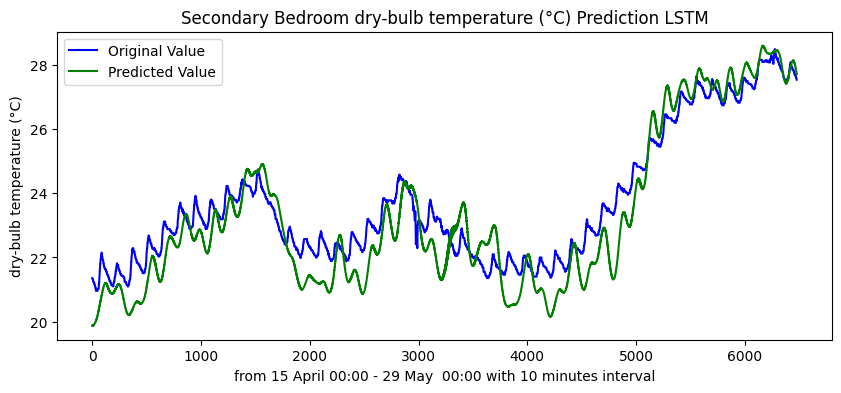

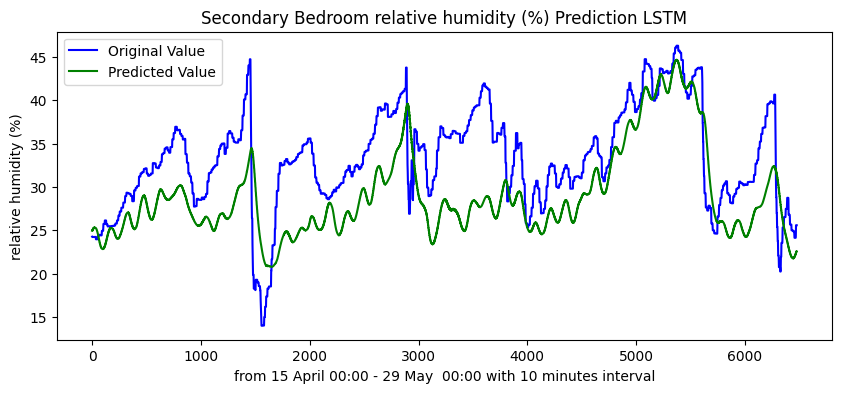

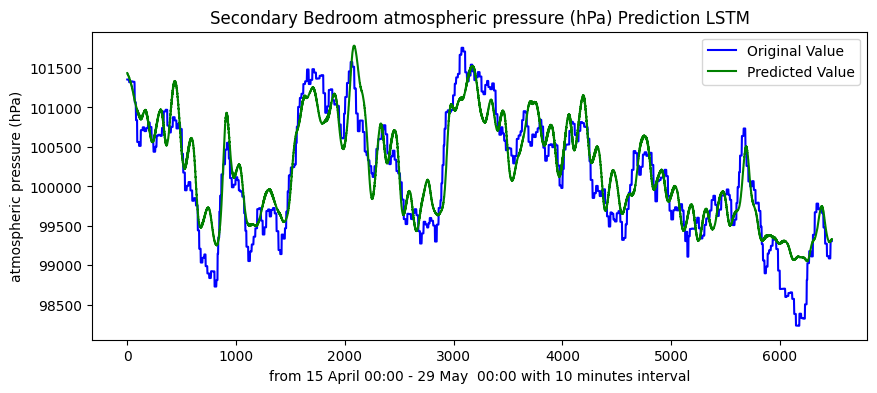


dry-bulb temperature (°C)
MAE: 0.903
MSE: 1.167
RMSE: 1.080

relative humidity (%)
MAE: 6.372
MSE: 55.501
RMSE: 7.450

atmospheric pressure (hPa)
MAE: 515.420
MSE: 417623.441
RMSE: 646.238


In [ ]:
finish(model_name='LSTM',room_number=4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_24                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_26                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_28                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 162s 318ms/step - loss: 0.5665 - mae: 0.1183 - val_loss: 0.0505 - val_mae: 0.0923 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0310 - mae: 0.0591 - val_loss: 0.0160 - val_mae: 0.0828 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0107 - mae: 0.0592 - val_loss: 0.0176 - val_mae: 0.1035 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0083 - mae: 0.0580 - val_loss: 0.0138 - val_mae: 0.0892 - learning_rate: 1.0000e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0081 - mae: 0.0574 - val_loss: 0.0136 - val_mae: 0.0890 - learning_rate: 1.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 0.0078 - mae: 0.0576 - val_loss: 0.0136 - val_mae: 0.0895 - learning_rate: 1.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 318ms/step - loss: 0.0078 - mae: 0.0573 - val_loss: 0.0138 - v

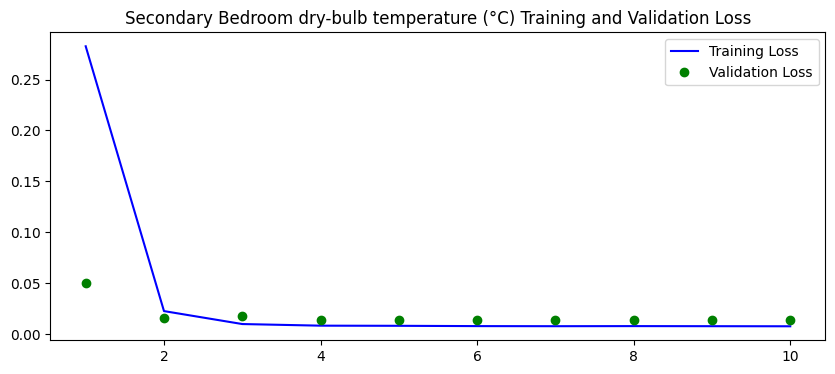

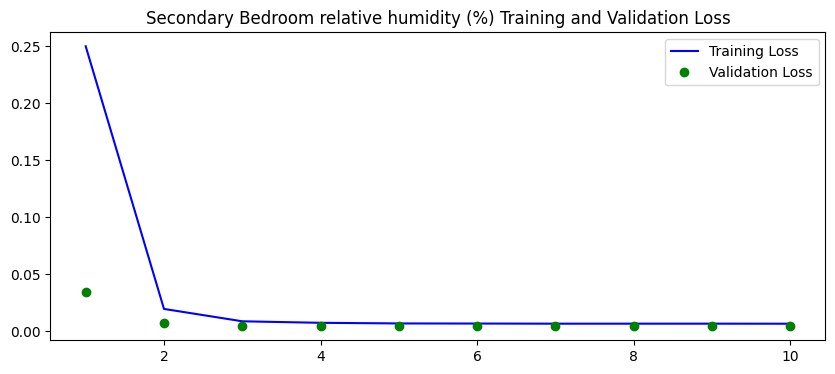

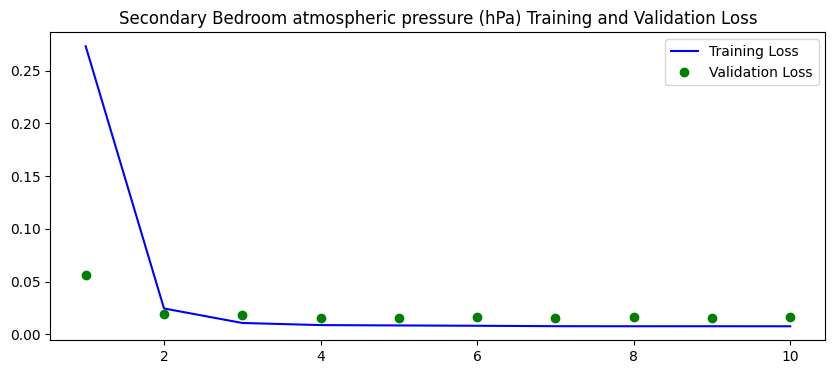

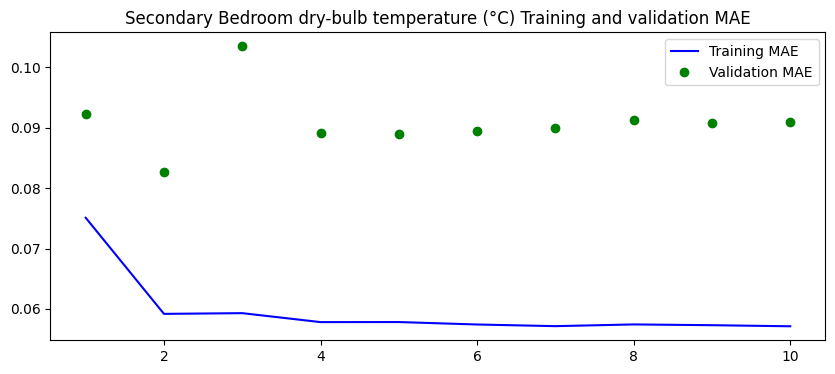

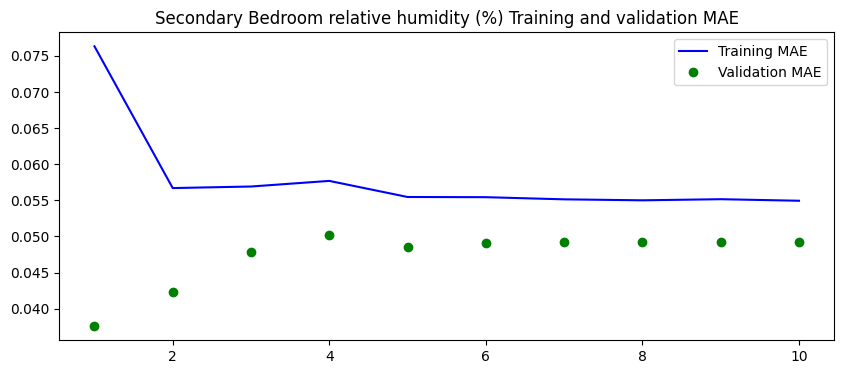

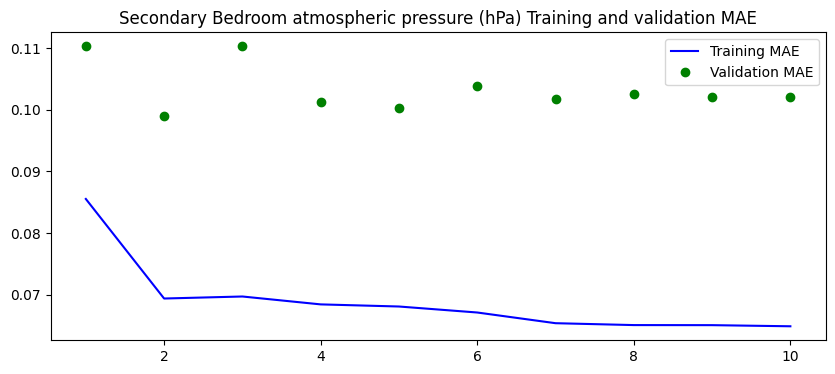

207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step



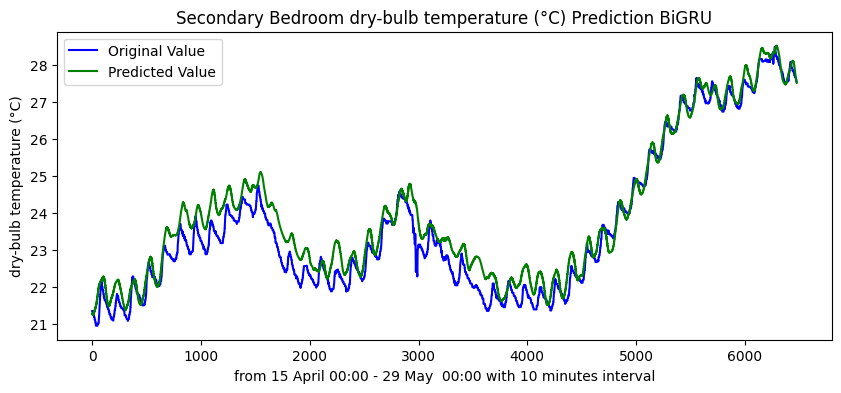

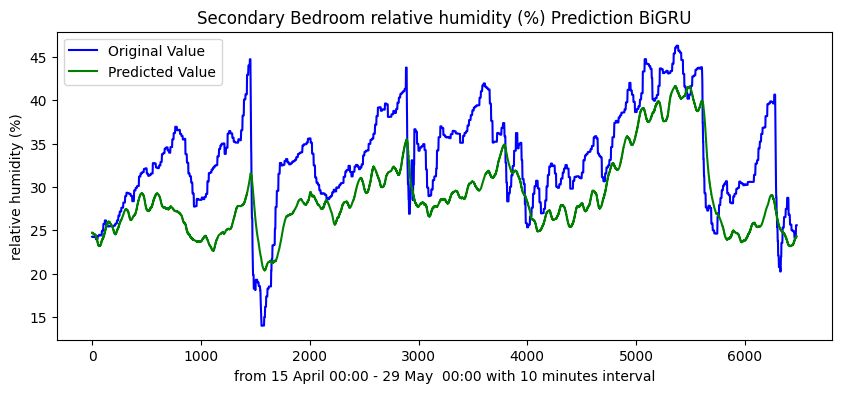

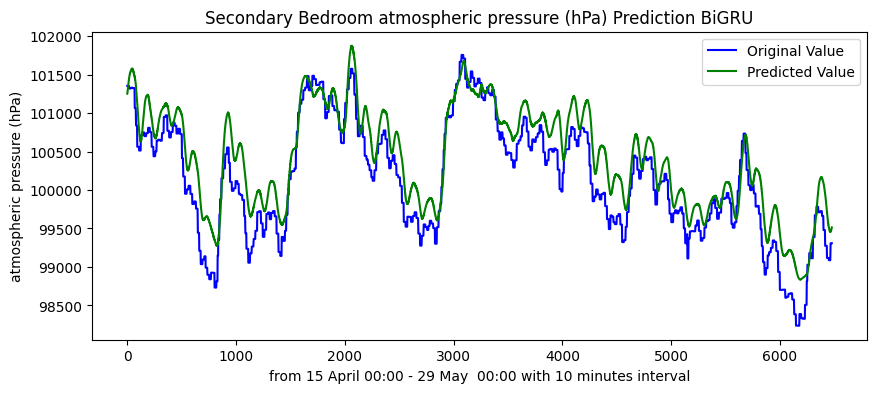


dry-bulb temperature (°C)
MAE: 0.536
MSE: 0.439
RMSE: 0.662

relative humidity (%)
MAE: 6.016
MSE: 50.569
RMSE: 7.111

atmospheric pressure (hPa)
MAE: 571.248
MSE: 490849.670
RMSE: 700.607


In [ ]:
finish(model_name='BiGRU',room_number=4)